# Robot dance: a city-wise automatic control of Covid-19 mitigation levels

Robot dance is an automatic control system that considers a complex network of cities with working mobility between them during the period of an epidemic. 
It proposes a control framework that suggests the level of protective measures, in order to avoid the collapse of the health system. 
The model is the following: let a graph with $K$ cities, each one with population $N_i$, and

$$
S_i + E_i + I_i + R_i = 1, i=1,\dots,K.
$$

Let $\alpha(t)$ be a binary coefficient function with $\alpha(t) = 1$ in the time spent at the original node and $\alpha(t) = 0$ during the day. 
Set $T_{\mathrm{inc}}$ and $T_{\mathrm{inf}}$ the incubation and the infection periods. 
During the night, the system works as a SEIR model, written as

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i,
\end{split}
$$

But the cities have commuting, which changes the dynamic of infections.
Let $p_{ij}$ represent the percentage of individuals of node $i$ that work at $j$.
The orginal model consideres that $p_{ij}(t)$ is a function of the time which decreases linearly with $r_j(t)$. 
Here we treat it as a constant.
During the day, the effective population at $i$ is $P_i^{\mathrm{eff}} = \sum_{j=1}^K p_{ji} N_j$.

The number of working people from $i$ that get exposed to infectious individuals from $j$ is 

$$
p_{ij} S_i(t) I_j^{\mathrm{eff}}(t),
$$

where the effective infection ratio is 

$$
I_j^{\mathrm{eff}}(t) = \frac{1}{P_j^{\mathrm{eff}}} \sum_{k=1}^K p_{kj} I_k N_k,
$$

that represents the number of incoming infected individuals from the other cities to $j$ normalized by the effective population there. 

The equations are, therefore, 

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) + (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i.
\end{split}
$$

We can say that $r_i(t) = \beta_i(t)/\gamma = \beta_i(t) T_{\mathrm{inf}}$.
The variable $r_j(t)$ is the control variable that means the reproductive number at time $t$ at city $j$.
They minimize a function changing this function. 

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

import sympy as sp
from scipy.sparse.linalg import eigs, svds
from scipy.linalg import eigvals

Matplotlib settings.

In [9]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

Model code without vaccination.

In [3]:
def model_ode(t, y, alpha, beta, tau, gamma, K, p_matrix, population, population_eff):
    """
    Defines a system of ordinary differential equations (ODEs) for a compartmental model in epidemiology.

    Parameters:
    t (float): The current time.
    y (array-like): The current state of the system. Should be a 1D array of length 4*K, 
                    where the first K elements represent the susceptible individuals, 
                    the next K elements represent the exposed individuals, 
                    the next K elements represent the infectious individuals, 
                    and the last K elements represent the recovered individuals.
    alpha (float): Proportion of the night among the 24 hours.
    beta (array-like): The transmission rate for each city. 
                       Should be a 1D array of length K.
    tau (float): The rate at which exposed individuals become infectious (the inverse of the incubation period).
    gamma (float): The recovery rate (the inverse of the infectious period).
    K (int): The number of cities or groups in the population.
    p_matrix (array-like): A matrix that represents the transitions between different cities. 
                           Should be a 2D array of shape (K, K).
    population (array-like): The total population in each city. 
                             Should be a 1D array of length K.
    population_eff (array-like): The effective population during the day.
                                 Should be a 1D array of length K.
                                 P_i^{\mathrm{eff}} = \sum_{j=1}^K p_matrix{ji} population_j
                                 
    Returns:
    array-like: The rates of change of the susceptible, exposed, infectious, and recovered individuals. 
                Returns a 1D array of length 4*K.
    """
    S, E, I, R = y[:K], y[K:2*K], y[2*K:3*K], y[3*K:]
    I_eff = (I * population) @ p_matrix / population_eff
    S_dot = -alpha * beta * S * I - (1-alpha) * S * (p_matrix @ (beta * I_eff))
    E_dot = -S_dot - tau * E
    I_dot = tau * E - gamma * I
    R_dot = gamma * I
    
    return np.hstack([S_dot, E_dot, I_dot, R_dot])

Calculating the $\mathcal{R}_0$.

In [4]:
def calculate_r0_isolate(beta, tau, gamma, mu):
    return (tau * beta) / ((gamma + mu) * (tau + mu))

def calculate_bounds(alpha, beta, p):
    K = len(beta)
    r0 = calculate_r0_isolate(beta, tau, gamma, mu)
    min_bound = np.min(alpha * r0 + (1 - alpha) * np.dot(p, r0))
    max_bound = np.max(alpha * r0 + (1 - alpha) * np.dot(p, r0))
    return min_bound, max_bound

def calculate_bounds_metropolitan(alpha, beta, p, population):
    K = len(beta)
    xi = max(alpha*beta[0], max(alpha * beta[1:] + (1-alpha) * beta[1:]))
    min_bound = calculate_r0_isolate(xi, tau, gamma, mu)
    max_bound = min_bound + calculate_r0_isolate((1-alpha)*beta[0]*np.dot(population, p[:,0]**2)/np.dot(population, p[:,0]), 
                                                 tau, gamma, mu)
    return min_bound, max_bound

def calculate_r0(beta, tau, gamma, mu, alpha, population_sizes, p_matrix):
    
    B = np.diag(beta)
    N = np.diag(population_sizes)
    population_eff = population_sizes @ p_matrix 
    E_inv = np.diag(1/population_eff)

    A = alpha * B + (1-alpha) * p_matrix @ B @ E_inv @ p_matrix.T @ N
    if len(beta) > 2:
        rho_A = abs(eigs(A, k=1, which='LM', return_eigenvectors=False)[0])
    else:
        rho_A = abs(eigvals(A)[0])
    return calculate_r0_isolate(rho_A, tau, gamma, mu)

We consider for the experiments a metropolitan area. 
Therefore, there is a centralized city that receives all the population.

## Two cities

We first set the parameters.

In [5]:
# number of cities
K = 2

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5

# No-fixed parameters
beta = np.array([0.4, 0.1])
p_21 = 0.2
alpha = 0.64
n1 = 10

# Population settings
population = np.array([n1, 1])
p_matrix = np.array([[1,0],[p_21, 1-p_21]])
population_eff = population @ p_matrix

Then, we can calculate the basic reproduction number and the corresponding bound.

In [6]:
print(r"R_0 = {}".format(calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)))
print("General bounds: ({}, {})".format(*calculate_bounds(alpha, beta, p_matrix)))
print("Metropolitan bounds: ({}, {})".format(*calculate_bounds_metropolitan(alpha, beta, p_matrix, population)))

R_0 = 2.78123615546766
General bounds: (0.8509447005069932, 2.799160199036162)
Metropolitan bounds: (1.7914625273831435, 2.783353176735722)


In [7]:
# No-fixed parameters
beta = np.array([0.4, 0.1])

alpha_values = np.linspace(0, 1.0, 100)
p_values = np.linspace(0, 0.9, 100)
n_values = np.array([1, 2, 5, 10])

r0_values = np.zeros((len(n_values), len(alpha_values), len(p_values)))

# Compute the spectral radius for each combination of alpha and p_21
for k, n1 in enumerate(n_values):
    population = np.array([n1, 1])
    for i, alpha in enumerate(alpha_values):
        for j, p_21 in enumerate(p_values):
            p_matrix = np.array([[1,0],[p_21, 1-p_21]])
            r0_values[k, i, j] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)

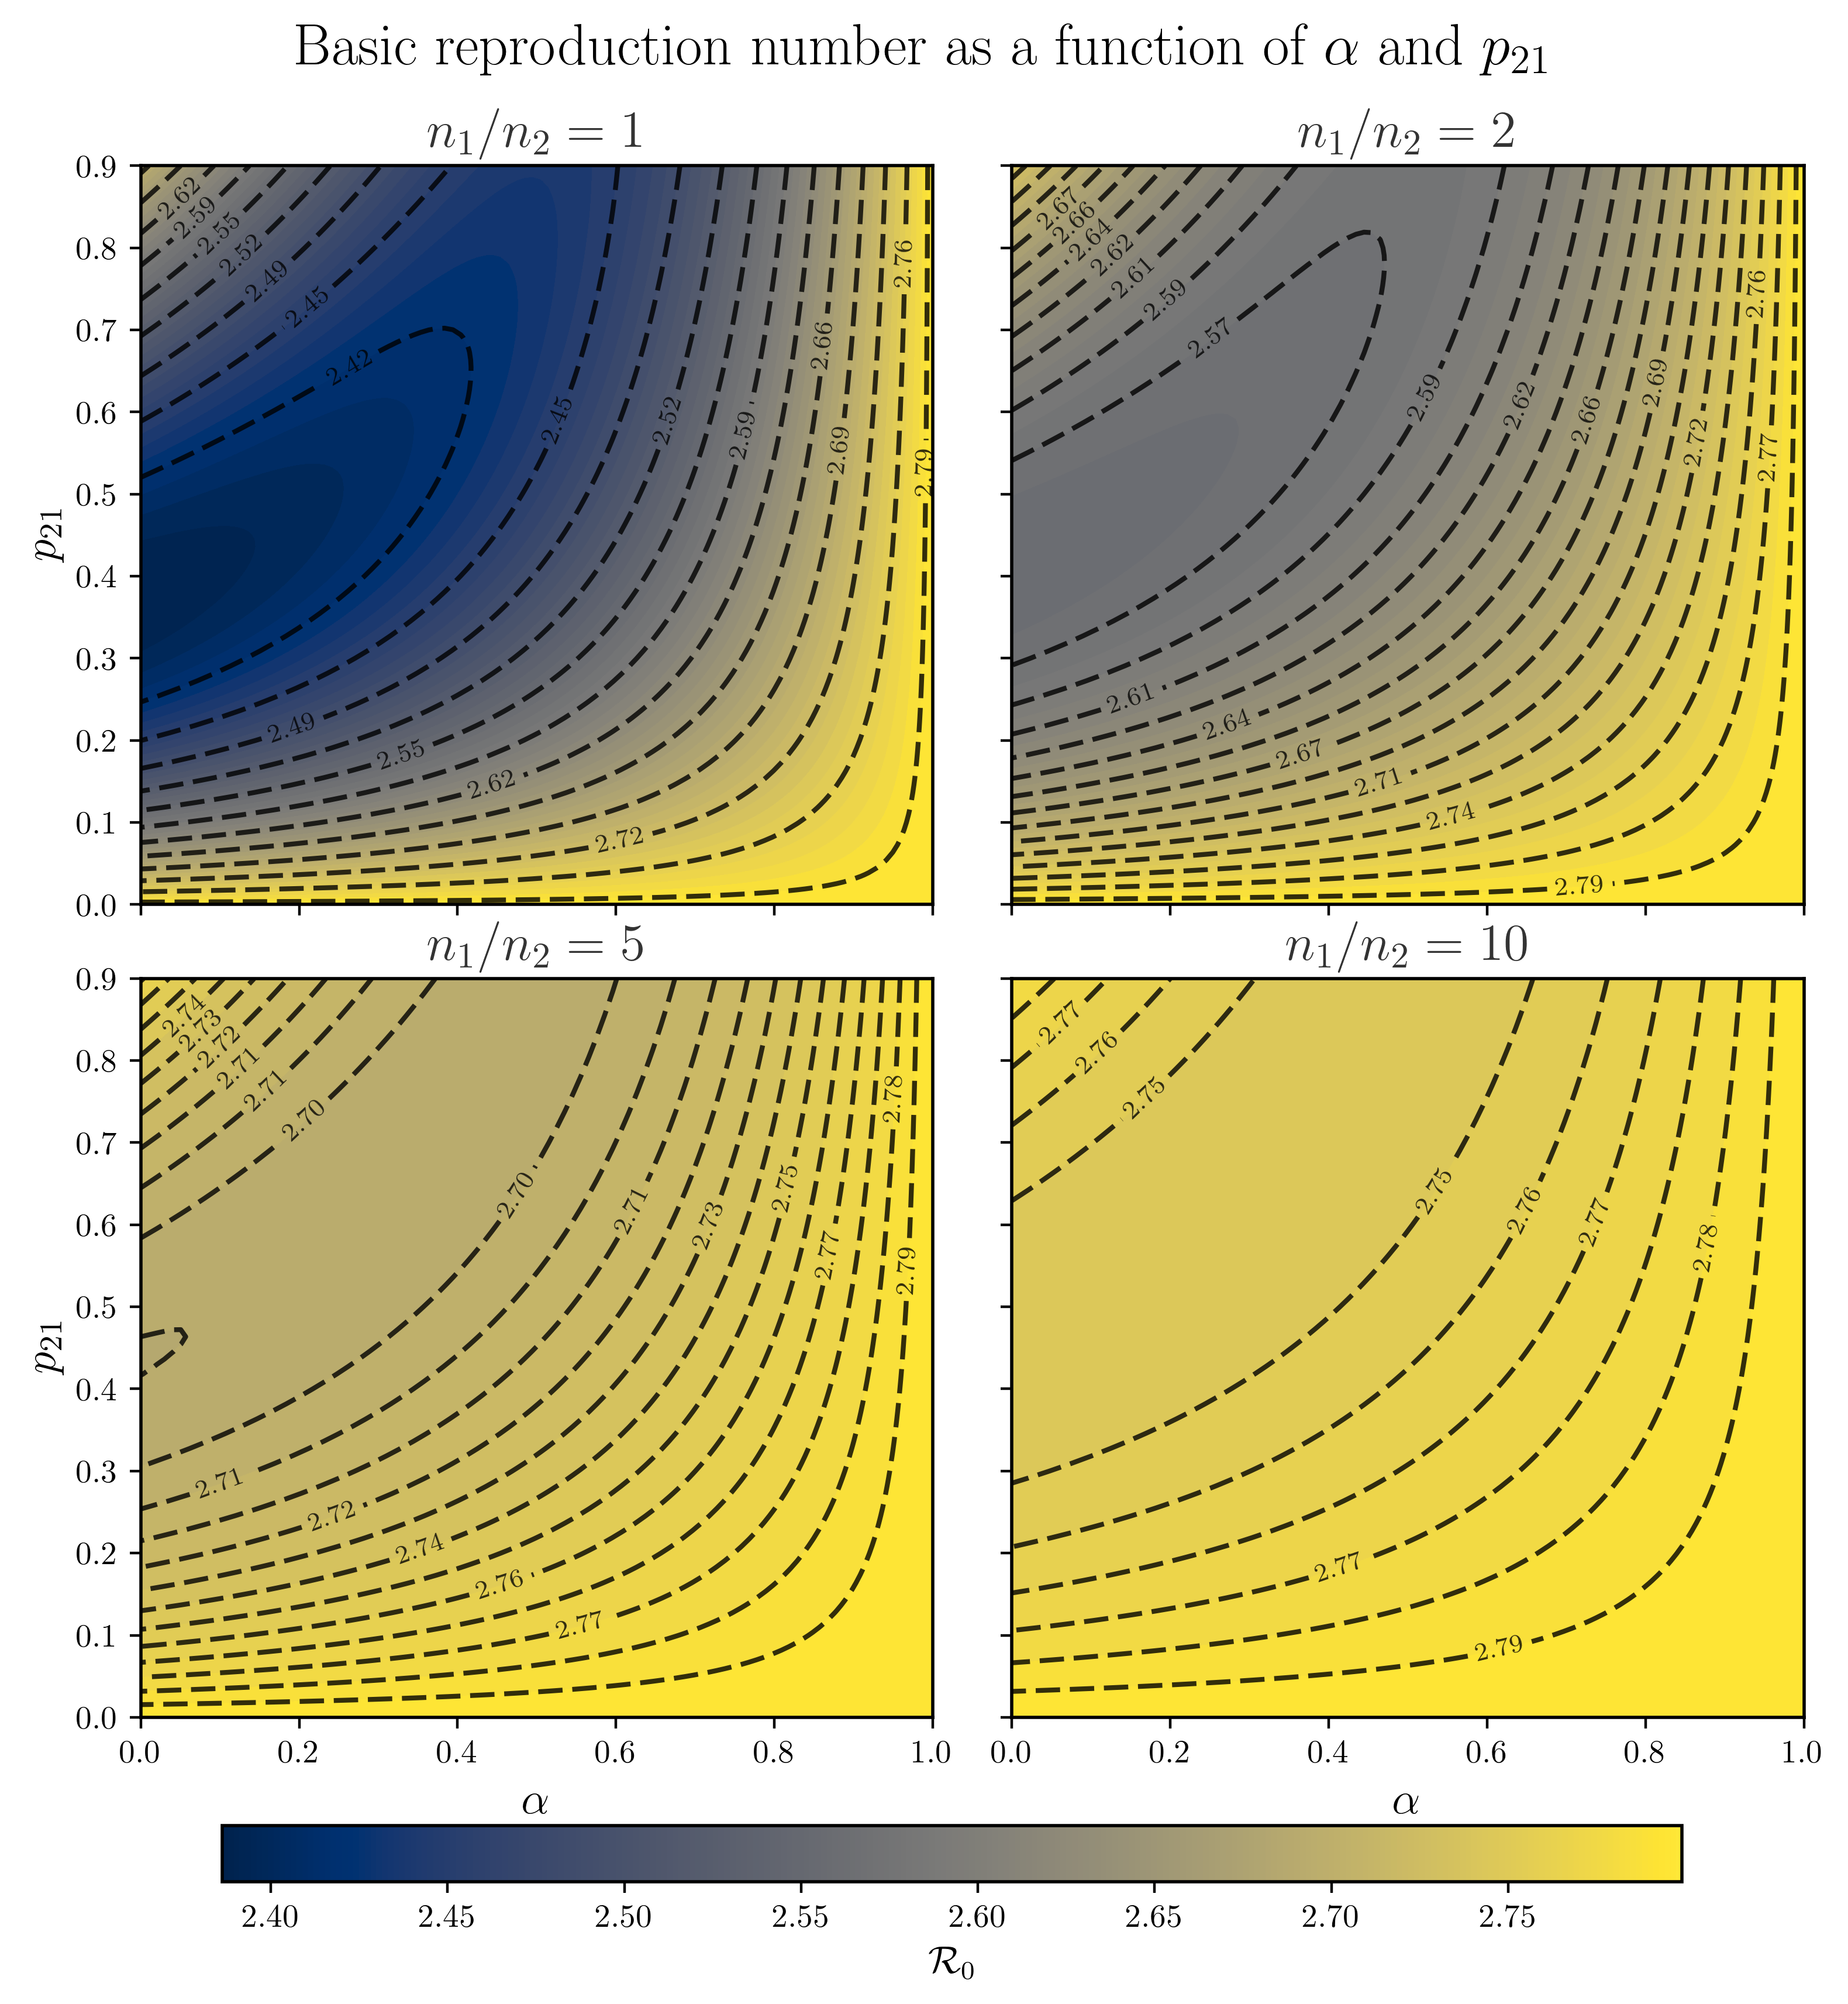

In [10]:
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

vmin = r0_values.min()
vmax = r0_values.max()

# Define the contour levels
levels = np.linspace(vmin, vmax, 50)
levels_lines = [4, 2, 1, 1]

for k, n1 in enumerate(n_values):
    
    i = k//2
    j = k%2
    
    ax[i,j].contourf(alpha_values, p_values, r0_values[k,:,:].T, cmap='cividis', levels=levels)
    contour = ax[i,j].contour(alpha_values, p_values, r0_values[k,:,:].T, colors='black', alpha=0.8,
                              levels=levels[::levels_lines[k]])
    for c in contour.collections:
        c.set_dashes([(0, (5.0, 2.0))])  # Set line style to dashed
    ax[i,j].clabel(contour, inline=True, fontsize=8, fmt='%1.2f')
    ax[i,j].set_title(r'$n_1/n_2 = {}$'.format(n1), color='black', alpha=0.8, fontsize=16)

ax[1,0].set_xlabel(r'$\alpha$', fontsize=14)
ax[1,1].set_xlabel(r'$\alpha$', fontsize=14)
ax[0,0].set_ylabel(r'$p_{21}$', fontsize=14)
ax[1,0].set_ylabel(r'$p_{21}$', fontsize=14)
fig.suptitle(r'Basic reproduction number as a function of $\alpha$ and $p_{21}$', fontsize=18)

plt.tight_layout()

cbar_ax = fig.add_axes([0.125, -0.013, 0.78, 0.03])

# Add the colorbar to the figure
fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='cividis'), 
             cax=cbar_ax, orientation='horizontal', label=r'$\mathcal{R}_0$')

fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('../images/r0_function_alpha_p21.pdf', bbox_inches='tight')
plt.show()

What is the marginal impact of $\alpha$ and $p_{21}$?

In [14]:
# No-fixed parameters
beta = np.array([0.15, 0.1])

alpha_values = np.linspace(0, 1.0, 100)
p_values = np.linspace(0, 0.9, 100)
n_values = np.array([1, 2, 5, 10])

r0_values = np.zeros((len(n_values), len(alpha_values), len(p_values)))

# Compute the spectral radius for each combination of alpha and p_21
for k, n1 in enumerate(n_values):
    population = np.array([n1, 1])
    for i, alpha in enumerate(alpha_values):
        for j, p_21 in enumerate(p_values):
            p_matrix = np.array([[1,0],[p_21, 1-p_21]])
            r0_values[k, i, j] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)

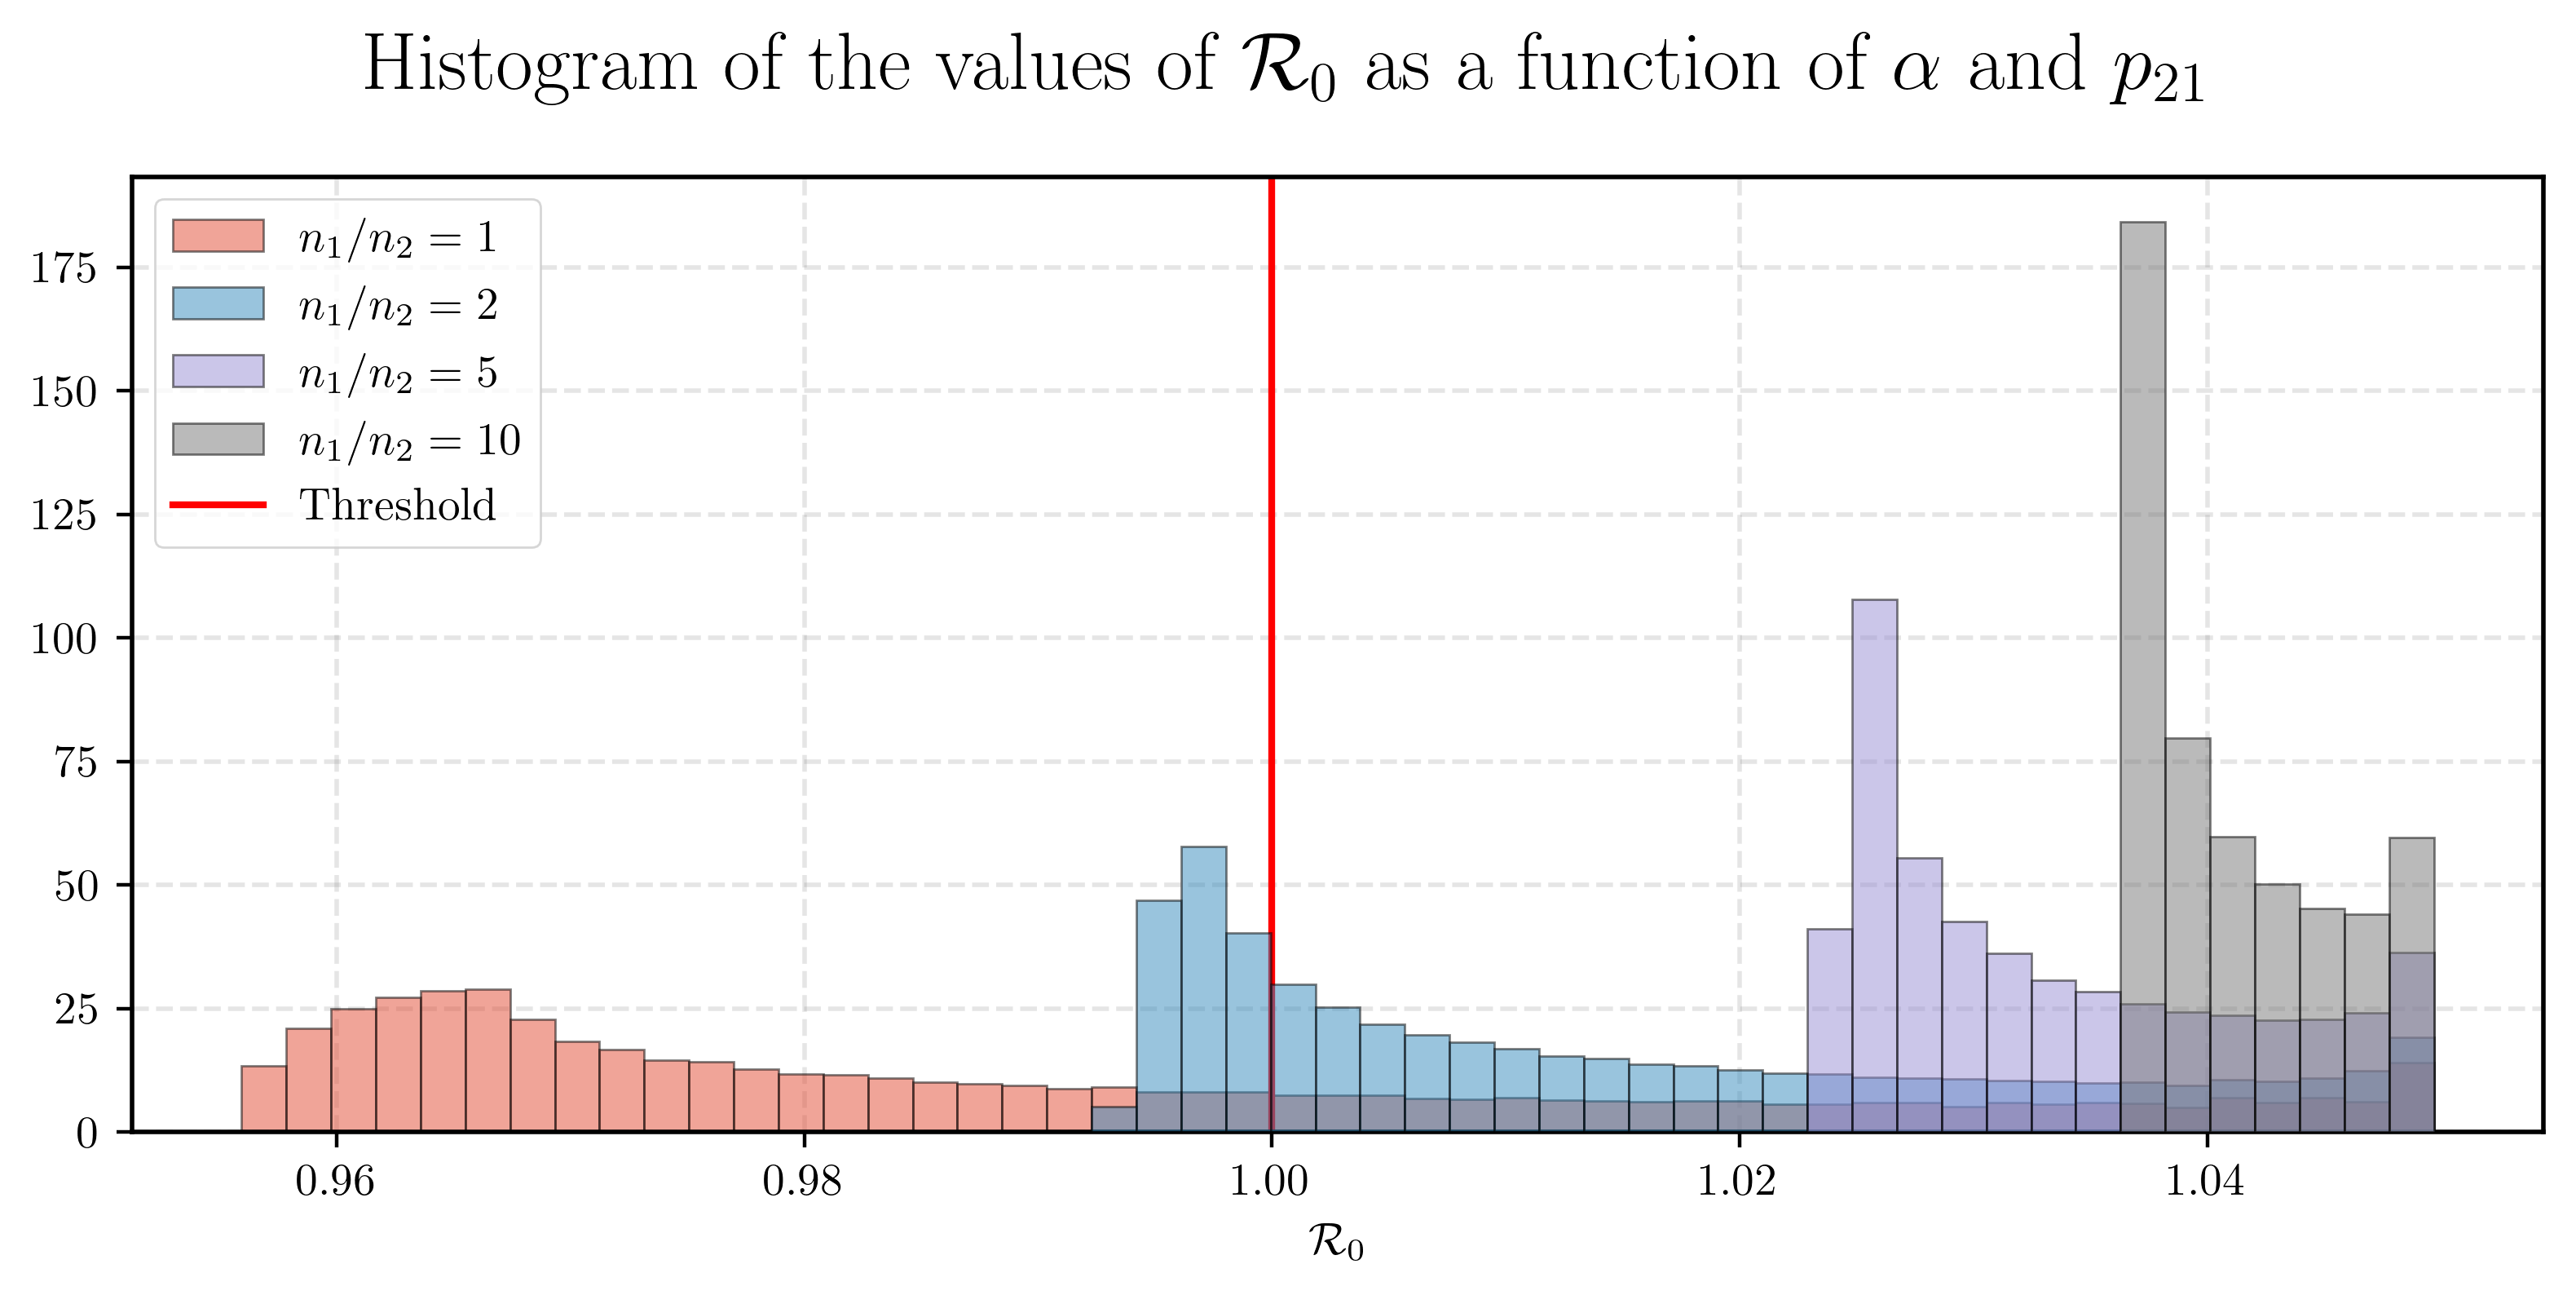

In [16]:
data = [np.ravel(r0_values[k,:,:]) for k in range(4)]

# Plotting
fig, ax = plt.subplots(figsize=(8,4))

ax.grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)

# Define the bins for the histogram
bins = np.linspace(np.min(data), np.max(data), 50)

# Plot a histogram for each data set
for i, n1 in enumerate(n_values):
    ax.hist(data[i], bins=bins, alpha=0.5, label=r'$n_1/n_2 = {}$'.format(n1), density=True, ec='black', zorder=i+2)

ax.set_xlabel(r'$\mathcal{R}_0$', fontsize=10)
fig.suptitle(r'Histogram of the values of $\mathcal{R}_0$ as a function of $\alpha$ and $p_{21}$', fontsize=18)

ax.axvline(1, color='red', label='Threshold')

# Add a legend to the plot
ax.legend()

plt.tight_layout()
plt.savefig('../images/r0_function_alpha_p21_smaller_beta.pdf', bbox_inches='tight')
plt.show()

What happens with the behaviour of $\mathcal{R}_0$ as a function of $\beta$?

In [12]:
# number of cities
K = 2

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5

# No-fixed parameters
p_21 = 0.2
alpha = 0.64
n1 = 10

# Population settings
population = np.array([n1, 1])
p_matrix = np.array([[1,0],[p_21, 1-p_21]])
population_eff = population @ p_matrix

# No-fixed parameters
beta = np.array([0.4, 0.1])

beta1_values = np.linspace(0.01, 0.3, 100)
beta2_values = np.linspace(0.01, 0.3, 100)

r0_values = np.zeros((100,100))

# Compute the spectral radius for each combination of alpha and beta_1
population = np.array([n1, 1])
for i, beta1 in enumerate(beta1_values):
    for j, beta2 in enumerate(beta2_values):
        beta = np.array([beta1, beta2])
        r0_values[i, j] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)

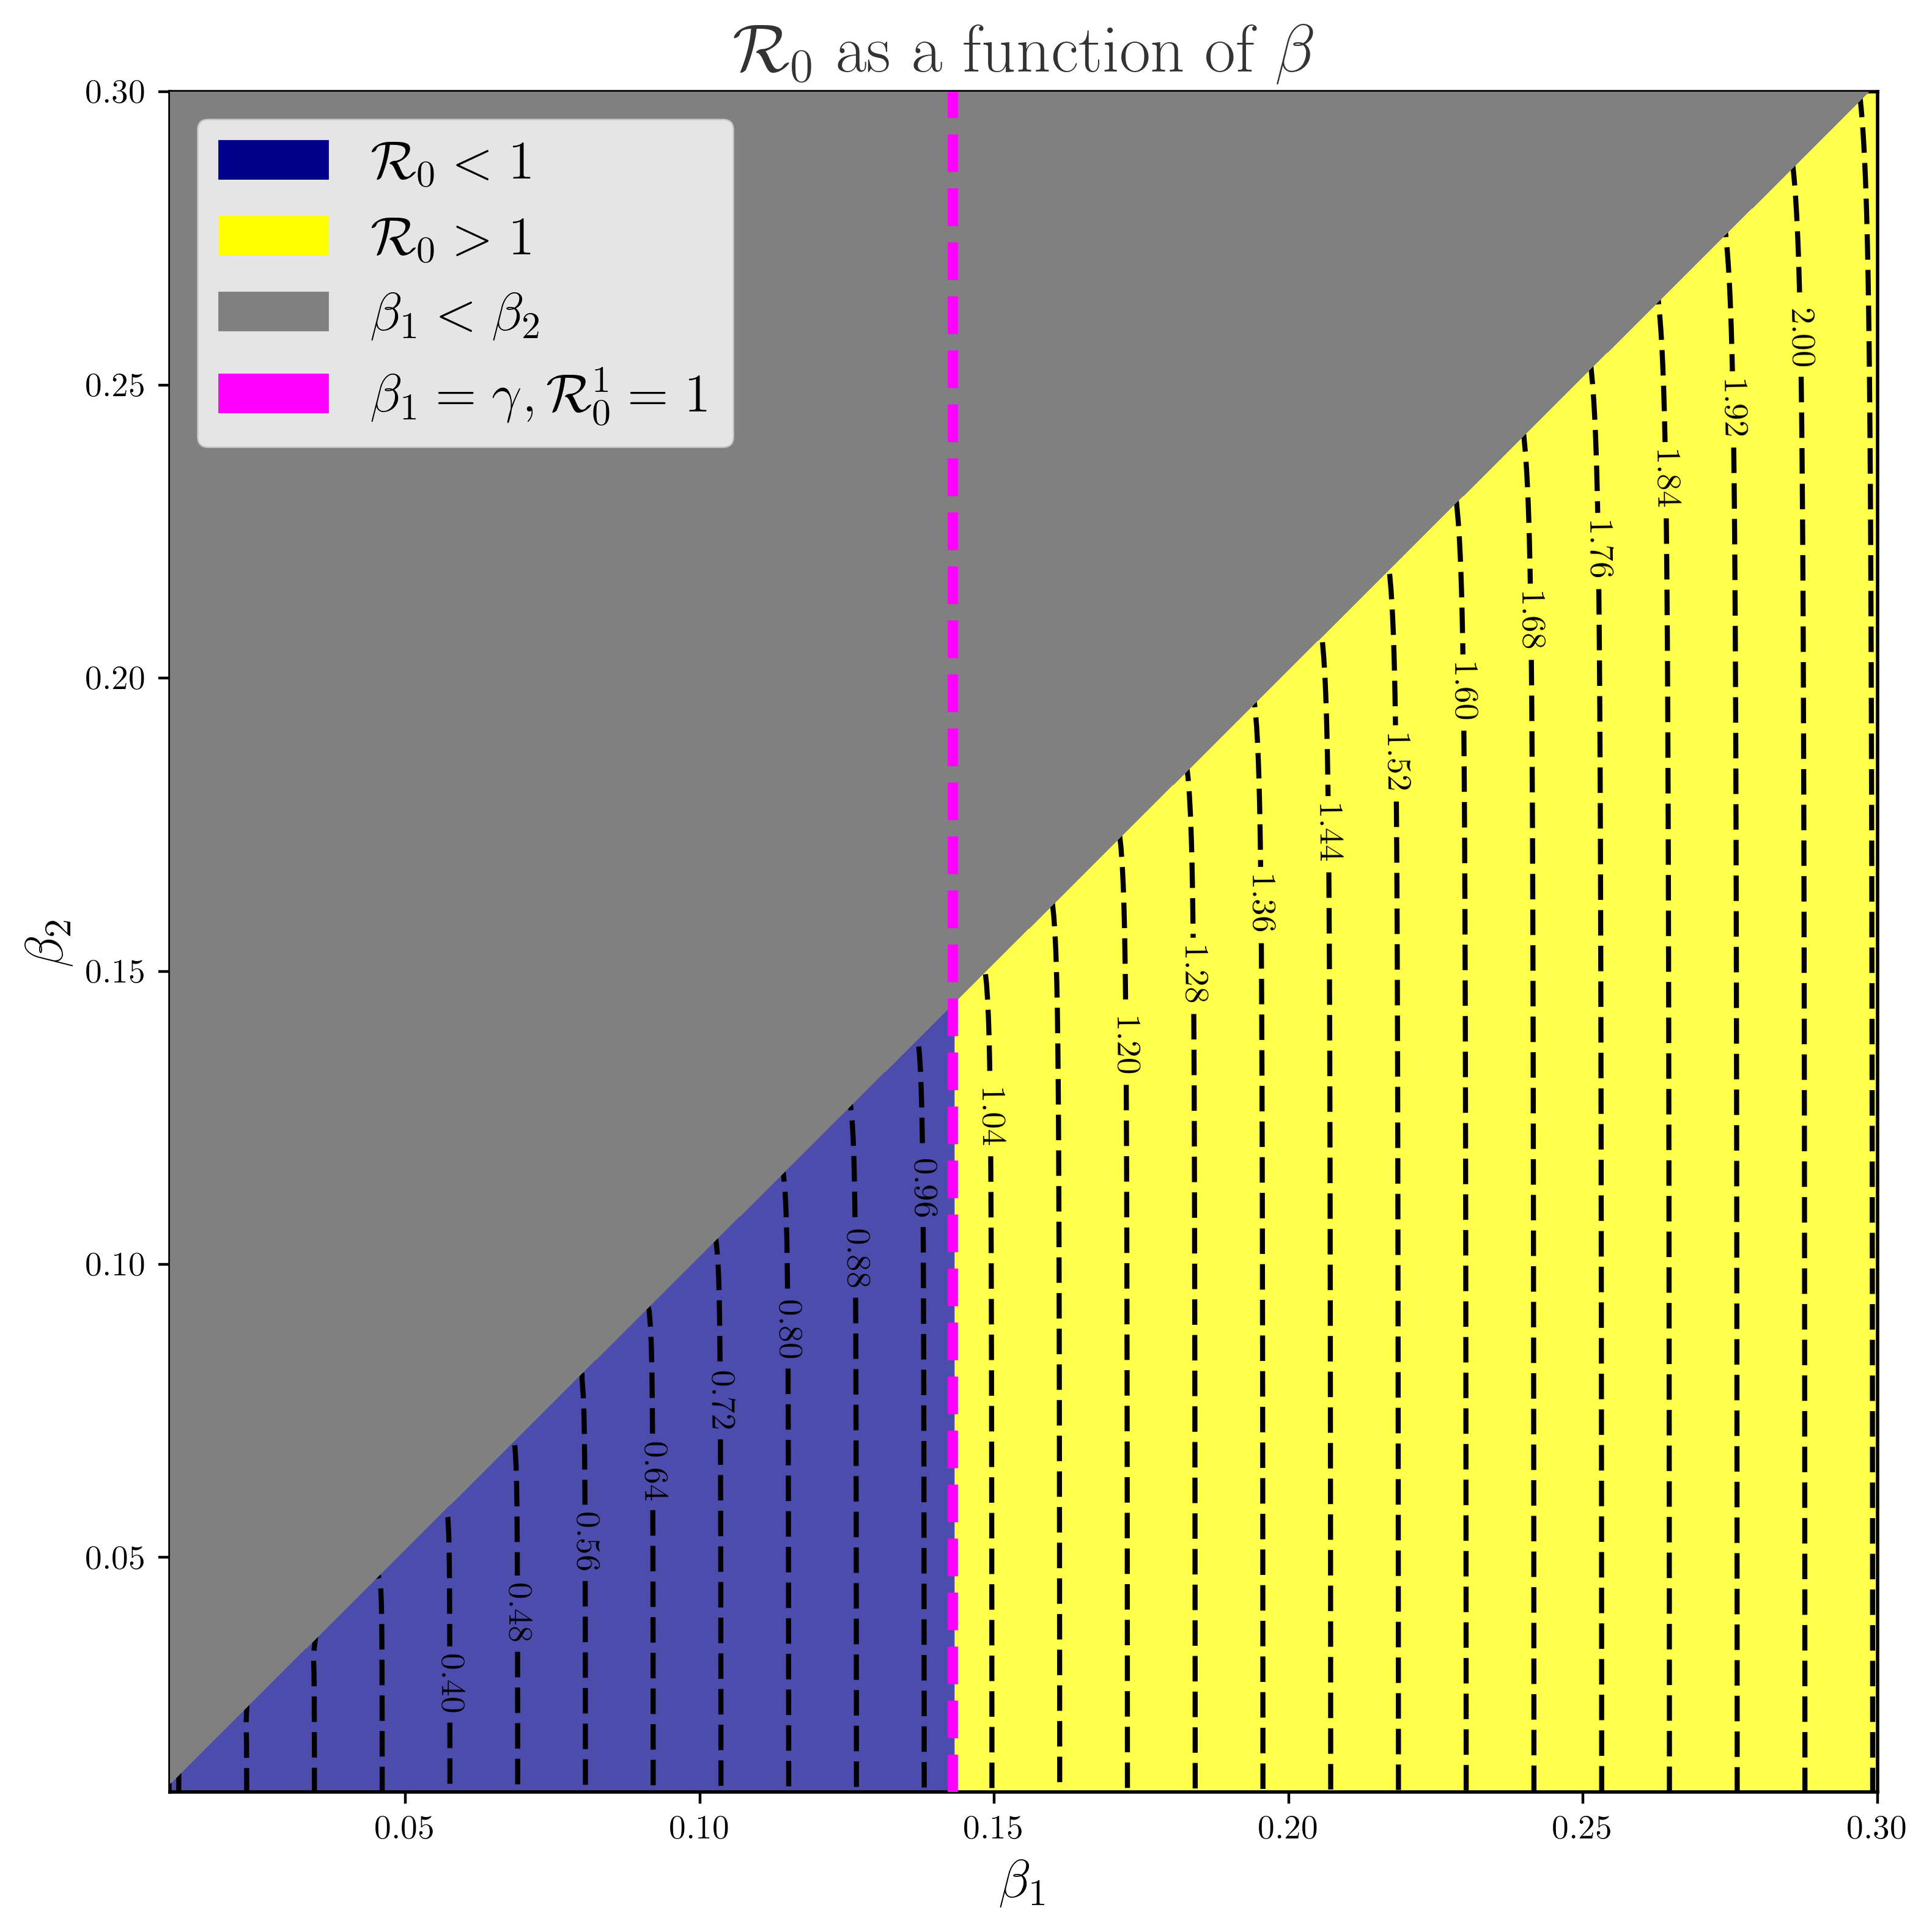

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

# Create masks for each condition
mask1 = np.where(beta1_values.reshape(-1,1) < beta2_values, 1, 0)
mask2 = np.where((r0_values > 0) & (r0_values < 1), 1, 0)
mask3 = np.where(r0_values > 1, 1, 0)

# Plot each mask with the desired color

ax.contourf(beta1_values, beta2_values, mask2.T, colors='darkblue', levels=[0.5, 1.5], alpha=0.7)
ax.contourf(beta1_values, beta2_values, mask3.T, colors='yellow', levels=[0.5, 1.5], alpha=0.7)

contour = ax.contour(beta1_values, beta2_values, r0_values.T, colors='black', alpha=1, levels=25)
for c in contour.collections:
    c.set_dashes([(0, (5.0, 2.0))])
manual_locations = [(x,x-0.03) for x in np.linspace(0.01, 0.3, 24, endpoint=False)][4:]
clabels = ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f', manual=manual_locations)

ax.set_title(r'$\mathcal{R}_0$ as a function of $\beta$', color='black', alpha=0.8, fontsize=20)

ax.set_xlabel(r'$\beta_1$', fontsize=16)
ax.set_ylabel(r'$\beta_2$', fontsize=16)

ax.axvline(gamma, color='magenta', ls='--', lw=3, zorder=6)  # Assuming gamma is defined

ax.contourf(beta1_values, beta2_values, mask1.T, colors='grey', levels=[0.5, 1.5], zorder=5)

legend_elements = [Patch(facecolor='darkblue', edgecolor='darkblue', label='$\mathcal{R}_0 < 1$'),
                   Patch(facecolor='yellow', edgecolor='yellow', label='$\mathcal{R}_0 > 1$'),
                   Patch(facecolor='grey', edgecolor='grey', label=r'$\beta_1 < \beta_2$'),
                   Patch(facecolor='magenta', edgecolor='magenta', label=r'$\beta_1 = \gamma, \mathcal{R}_0^1 = 1$')]
ax.legend(handles=legend_elements, loc='upper left', fancybox=True, fontsize=16)

plt.tight_layout()
plt.savefig('../images/r0_function_beta.pdf', bbox_inches='tight')
plt.show()

How do the bounds behave?

In [17]:
# number of cities
K = 2

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
beta = np.array([0.4, 0.1])
alpha = 0.64
p_21 = 0.2
n1 = 10

# Population settings
population = np.array([n1, 1])
p_matrix = np.array([[1,0],[p_21, 1-p_21]])
population_eff = population @ p_matrix

In [18]:
variable_parameters = [
    np.linspace(0, 1, 100),       #alpha
    np.linspace(0.05, 0.95, 100), #p21
    np.linspace(0.1, 0.5, 100),   #beta1
    np.linspace(0.05,0.35,100)         #n1
]
parameters = [r'$\alpha$', r'$p_{21}$', r'$\beta_1$', r'$\beta_2$']

r0_values = np.zeros((4, 100))
lb_values = np.zeros_like(r0_values)
ub_values = np.zeros_like(r0_values)
lb_values_met = np.zeros_like(r0_values)
ub_values_met = np.zeros_like(r0_values)

for i, alpha in enumerate(variable_parameters[0]):
    
    r0_values[0,i] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)
    lb_values[0,i], ub_values[0,i] = calculate_bounds(alpha, beta, p_matrix)
    lb_values_met[0,i], ub_values_met[0,i] = calculate_bounds_metropolitan(alpha, beta, p_matrix, population)

alpha = 0.64

for i, p_21 in enumerate(variable_parameters[1]):
    
    p_matrix = np.array([[1,0],[p_21, 1-p_21]])
    r0_values[1,i] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)
    lb_values[1,i], ub_values[1,i] = calculate_bounds(alpha, beta, p_matrix)
    lb_values_met[1,i], ub_values_met[1,i] = calculate_bounds_metropolitan(alpha, beta, p_matrix, population)
    
p_21 = 0.2
p_matrix = np.array([[1,0],[p_21, 1-p_21]])

for i, beta1 in enumerate(variable_parameters[2]):
    
    beta[0] = beta1
    r0_values[2,i] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)
    lb_values[2,i], ub_values[2,i] = calculate_bounds(alpha, beta, p_matrix)
    lb_values_met[2,i], ub_values_met[2,i] = calculate_bounds_metropolitan(alpha, beta, p_matrix, population)
    
beta1 = 0.4
beta[0] = beta1

for i, beta2 in enumerate(variable_parameters[3]):
    
    #population = np.array([n1, 1])
    beta[1] = beta2
    r0_values[3,i] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)
    lb_values[3,i], ub_values[3,i] = calculate_bounds(alpha, beta, p_matrix)
    lb_values_met[3,i], ub_values_met[3,i] = calculate_bounds_metropolitan(alpha, beta, p_matrix, population)

beta2 = 0.1
beta[1] = beta2

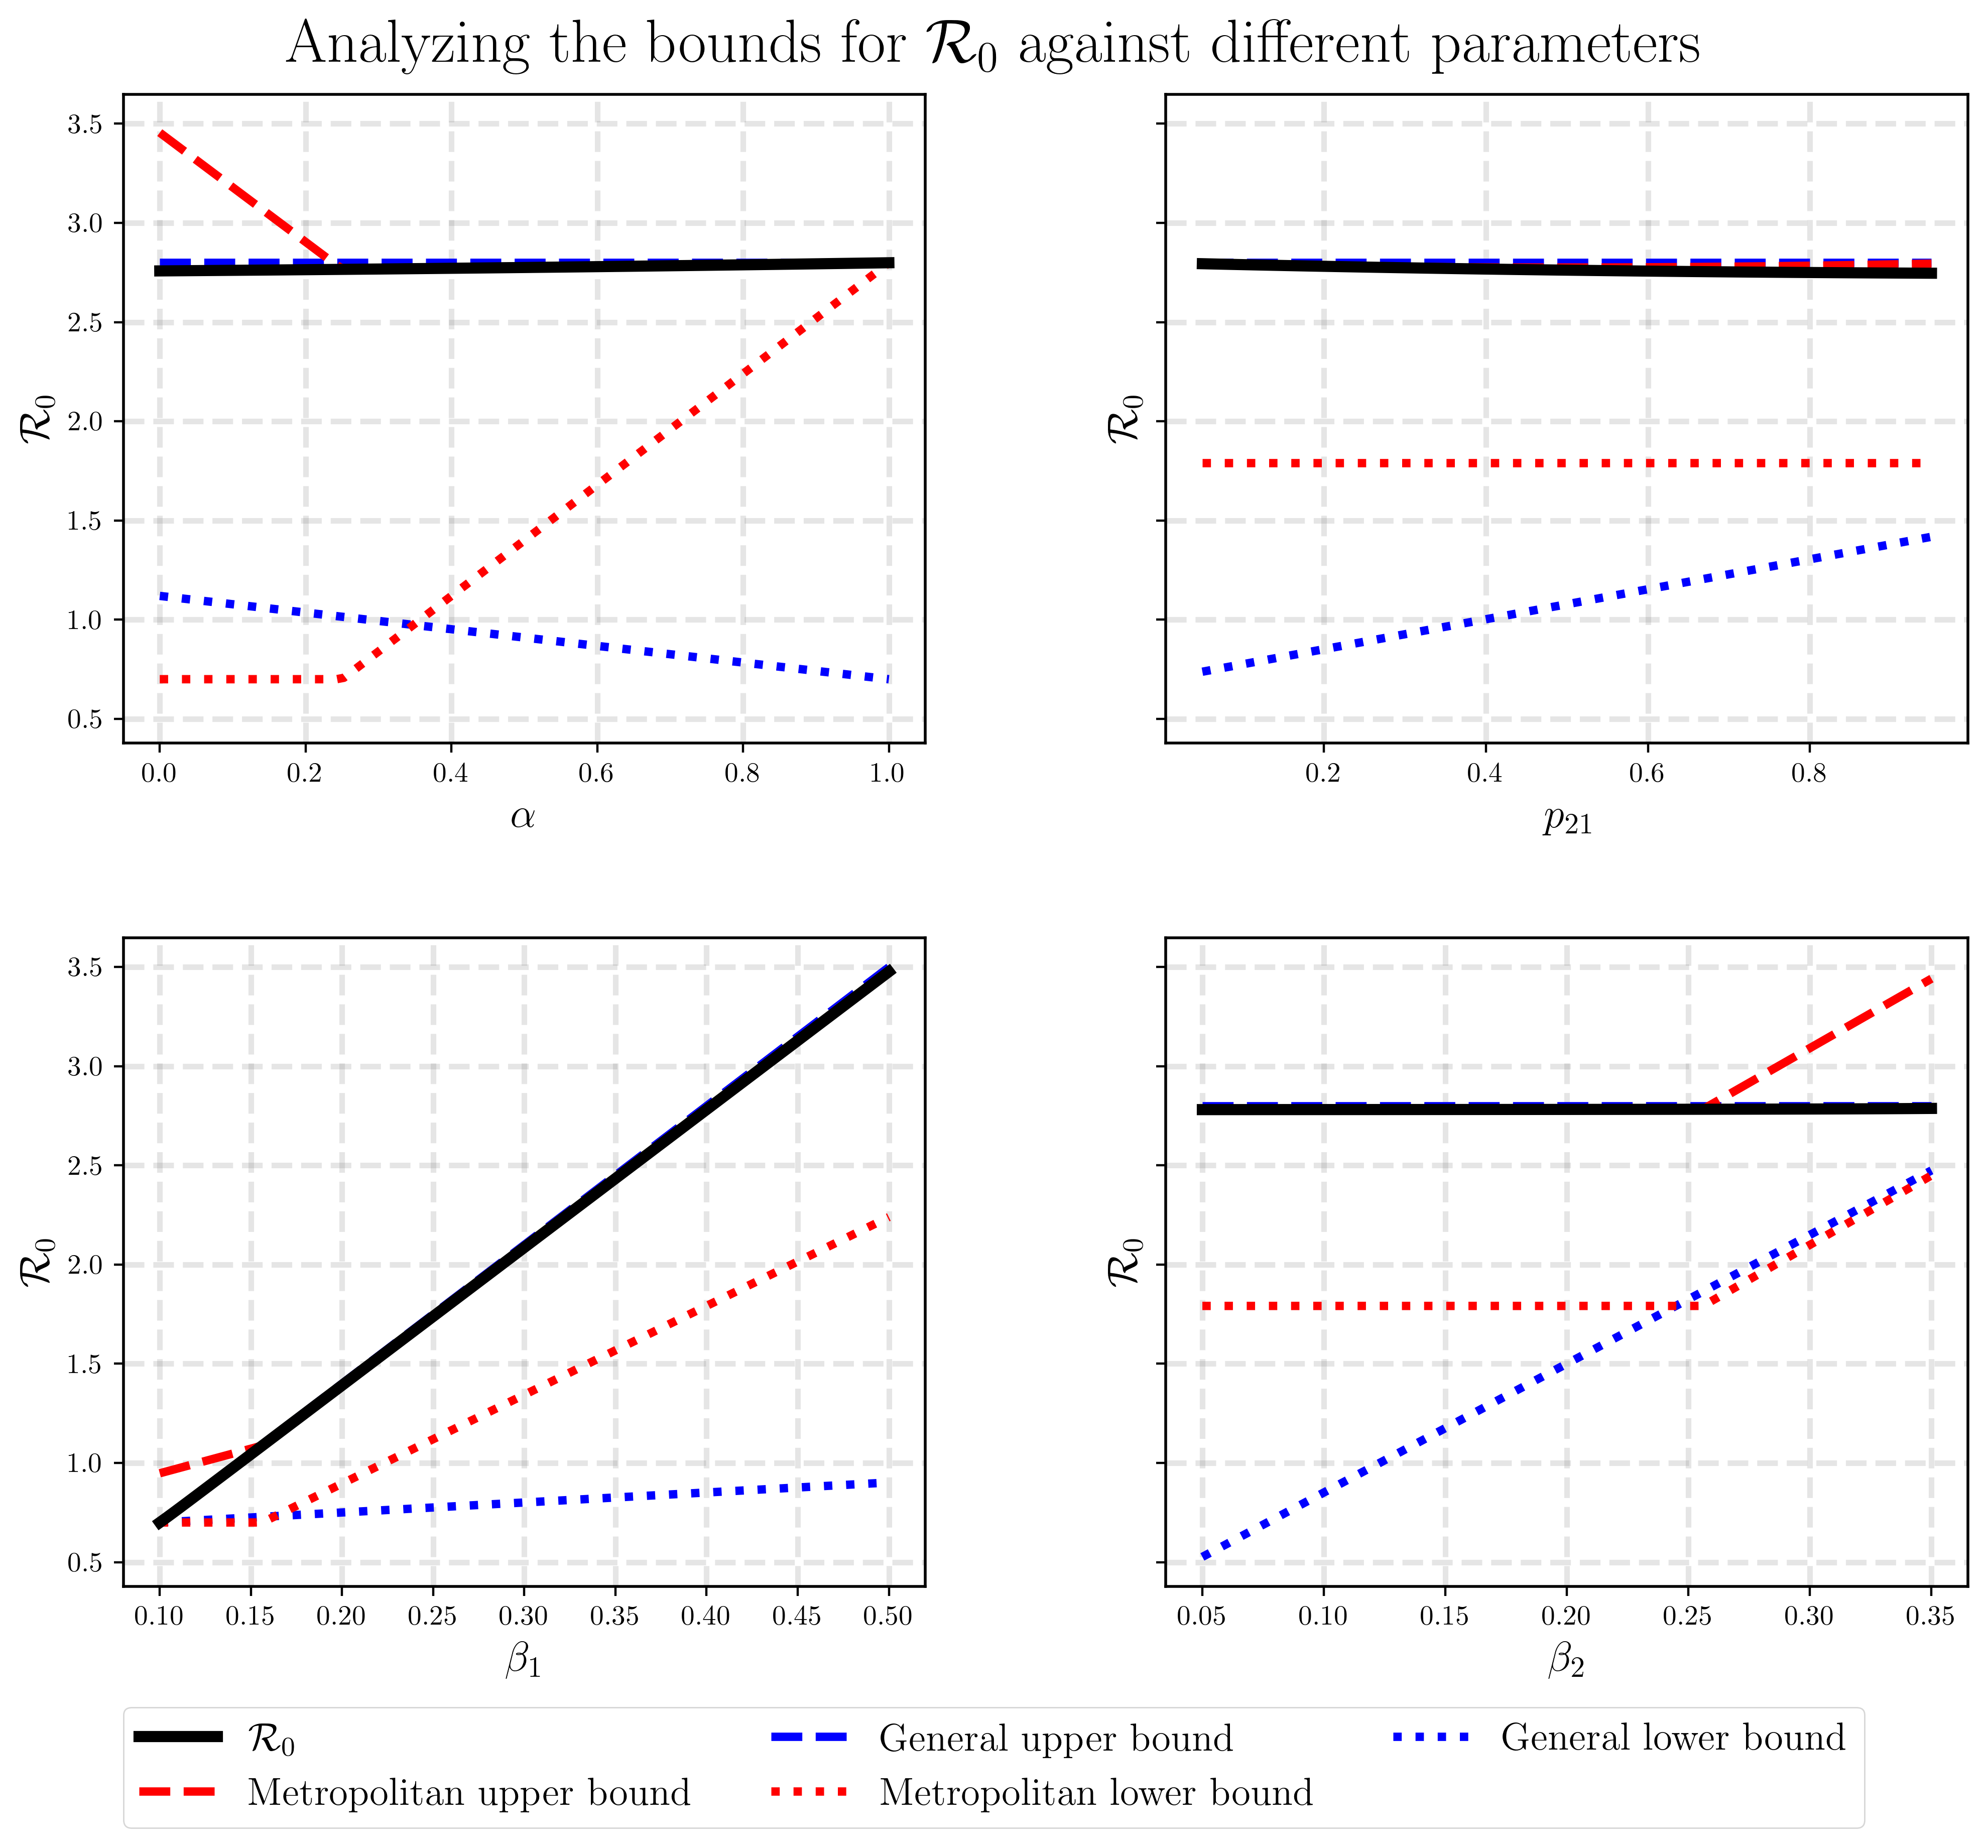

In [22]:
fig, ax = plt.subplots(2,2,figsize=(10,10), sharey=True)

for k in range(4):
    
    i = k//2
    j = k%2
    
    ax[i,j].plot(variable_parameters[k], ub_values[k,:], lw=3, ls='--', color='blue')
    ax[i,j].plot(variable_parameters[k], lb_values[k,:], lw=3, ls=':', color='blue')
    ax[i,j].plot(variable_parameters[k], ub_values_met[k,:], lw=3, ls='--', color='red')
    ax[i,j].plot(variable_parameters[k], lb_values_met[k,:], lw=3, ls=':', color='red')
    ax[i,j].grid(color='grey', linestyle='--', lw=2, alpha=0.2, zorder=1)
    ax[i,j].set_xlabel(parameters[k], fontsize=15)
    ax[i,j].set_ylabel(r'$\mathcal{R}_0$', fontsize=15)
    
    ax[i,j].plot(variable_parameters[k], r0_values[k,:], color='black', lw=4)

# Define the legend entries manually
line1 = Line2D([0], [0], color='black', lw=4)
line3 = Line2D([0], [0], color='blue', lw=3, ls='--')
line5 = Line2D([0], [0], color='blue', lw=3, ls=':')
line2 = Line2D([0], [0], color='red', lw=3, ls='--')
line4 = Line2D([0], [0], color='red', lw=3, ls=':')

fig.legend([line1, line2, line3, line4, line5], 
           [r'$\mathcal{R}_0$', 'Metropolitan upper bound', 'General upper bound', 'Metropolitan lower bound', 'General lower bound'], 
           loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.07), fancybox=True, fontsize=14)
fig.suptitle(r'Analyzing the bounds for $\mathcal{R}_0$ against different parameters', fontsize=22)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2, hspace=0.3, wspace=0.3)
plt.savefig('../images/r0_bounds.pdf', bbox_inches='tight')
plt.show()

In [23]:
ro = np.random.RandomState(seed=83921)

# number of cities
K = 2

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5

N = 100000
r0_values = np.zeros(N)
lb_values = np.zeros_like(r0_values)
ub_values = np.zeros_like(r0_values)
lb_values_met = np.zeros_like(r0_values)
ub_values_met = np.zeros_like(r0_values)
lb_better = np.zeros_like(r0_values)
ub_better = np.zeros_like(r0_values)

for i in range(N):

    beta2 = ro.uniform(0.01, 0.2)
    beta1 = ro.uniform(beta2, 0.6)
    beta = np.array([beta1, beta2])
    alpha = ro.uniform(0.5,1)
    p_21 = ro.uniform(0,0.9)
    n1 = ro.randint(1,10)

    # Population settings
    population = np.array([n1, 1])
    p_matrix = np.array([[1,0],[p_21, 1-p_21]])
    
    r0_values[i] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)
    lb_values[i], ub_values[i] = calculate_bounds(alpha, beta, p_matrix)
    lb_values_met[i], ub_values_met[i] = calculate_bounds_metropolitan(alpha, beta, p_matrix, population)
    
    
    lb_better[i] = 1*(lb_values[i] > lb_values_met[i])
    ub_better[i] = 1*(ub_values[i] < ub_values_met[i])

In [24]:
print("Metropolitan has better bounds: {:.1f}%".format(100*np.mean((1-ub_better)*(1-lb_better))))
print("Metropolitan has only better upper bound: {:.1f}%".format(100*np.mean((1-ub_better)*lb_better)))
print("Metropolitan has only better lower bound: {:.1f}%".format(100*np.mean(ub_better*(1-lb_better))))
print("Metropolitan has worst bounds: {:.1f}%".format(100*np.mean(ub_better*lb_better)))

Metropolitan has better bounds: 87.1%
Metropolitan has only better upper bound: 4.9%
Metropolitan has only better lower bound: 0.0%
Metropolitan has worst bounds: 8.1%


Now, we fix the initial conditions. 
We consider the beggining of the disease, so only the capital has the disease with an exposed individual.

In [25]:
# number of cities
K = 2

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
betas = [
    np.array([0.5, 0.2]),
    np.array([0.2, 0.15]),
    np.array([0.3, 0.1]),
    np.array([0.1, 0.08])
]
alpha = 0.64
p_21 = 0.2
n1 = 10

# Population settings
population = 1e6*np.array([n1, 1])
p_matrix = np.array([[1,0],[p_21, 1-p_21]])
population_eff = population @ p_matrix

# Initial condition
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 1/population[0]
y0[0] = 1-y0[K]

n_days = 400
t_eval = np.linspace(0, n_days, 100 * n_days)
sol = [0,0,0,0]

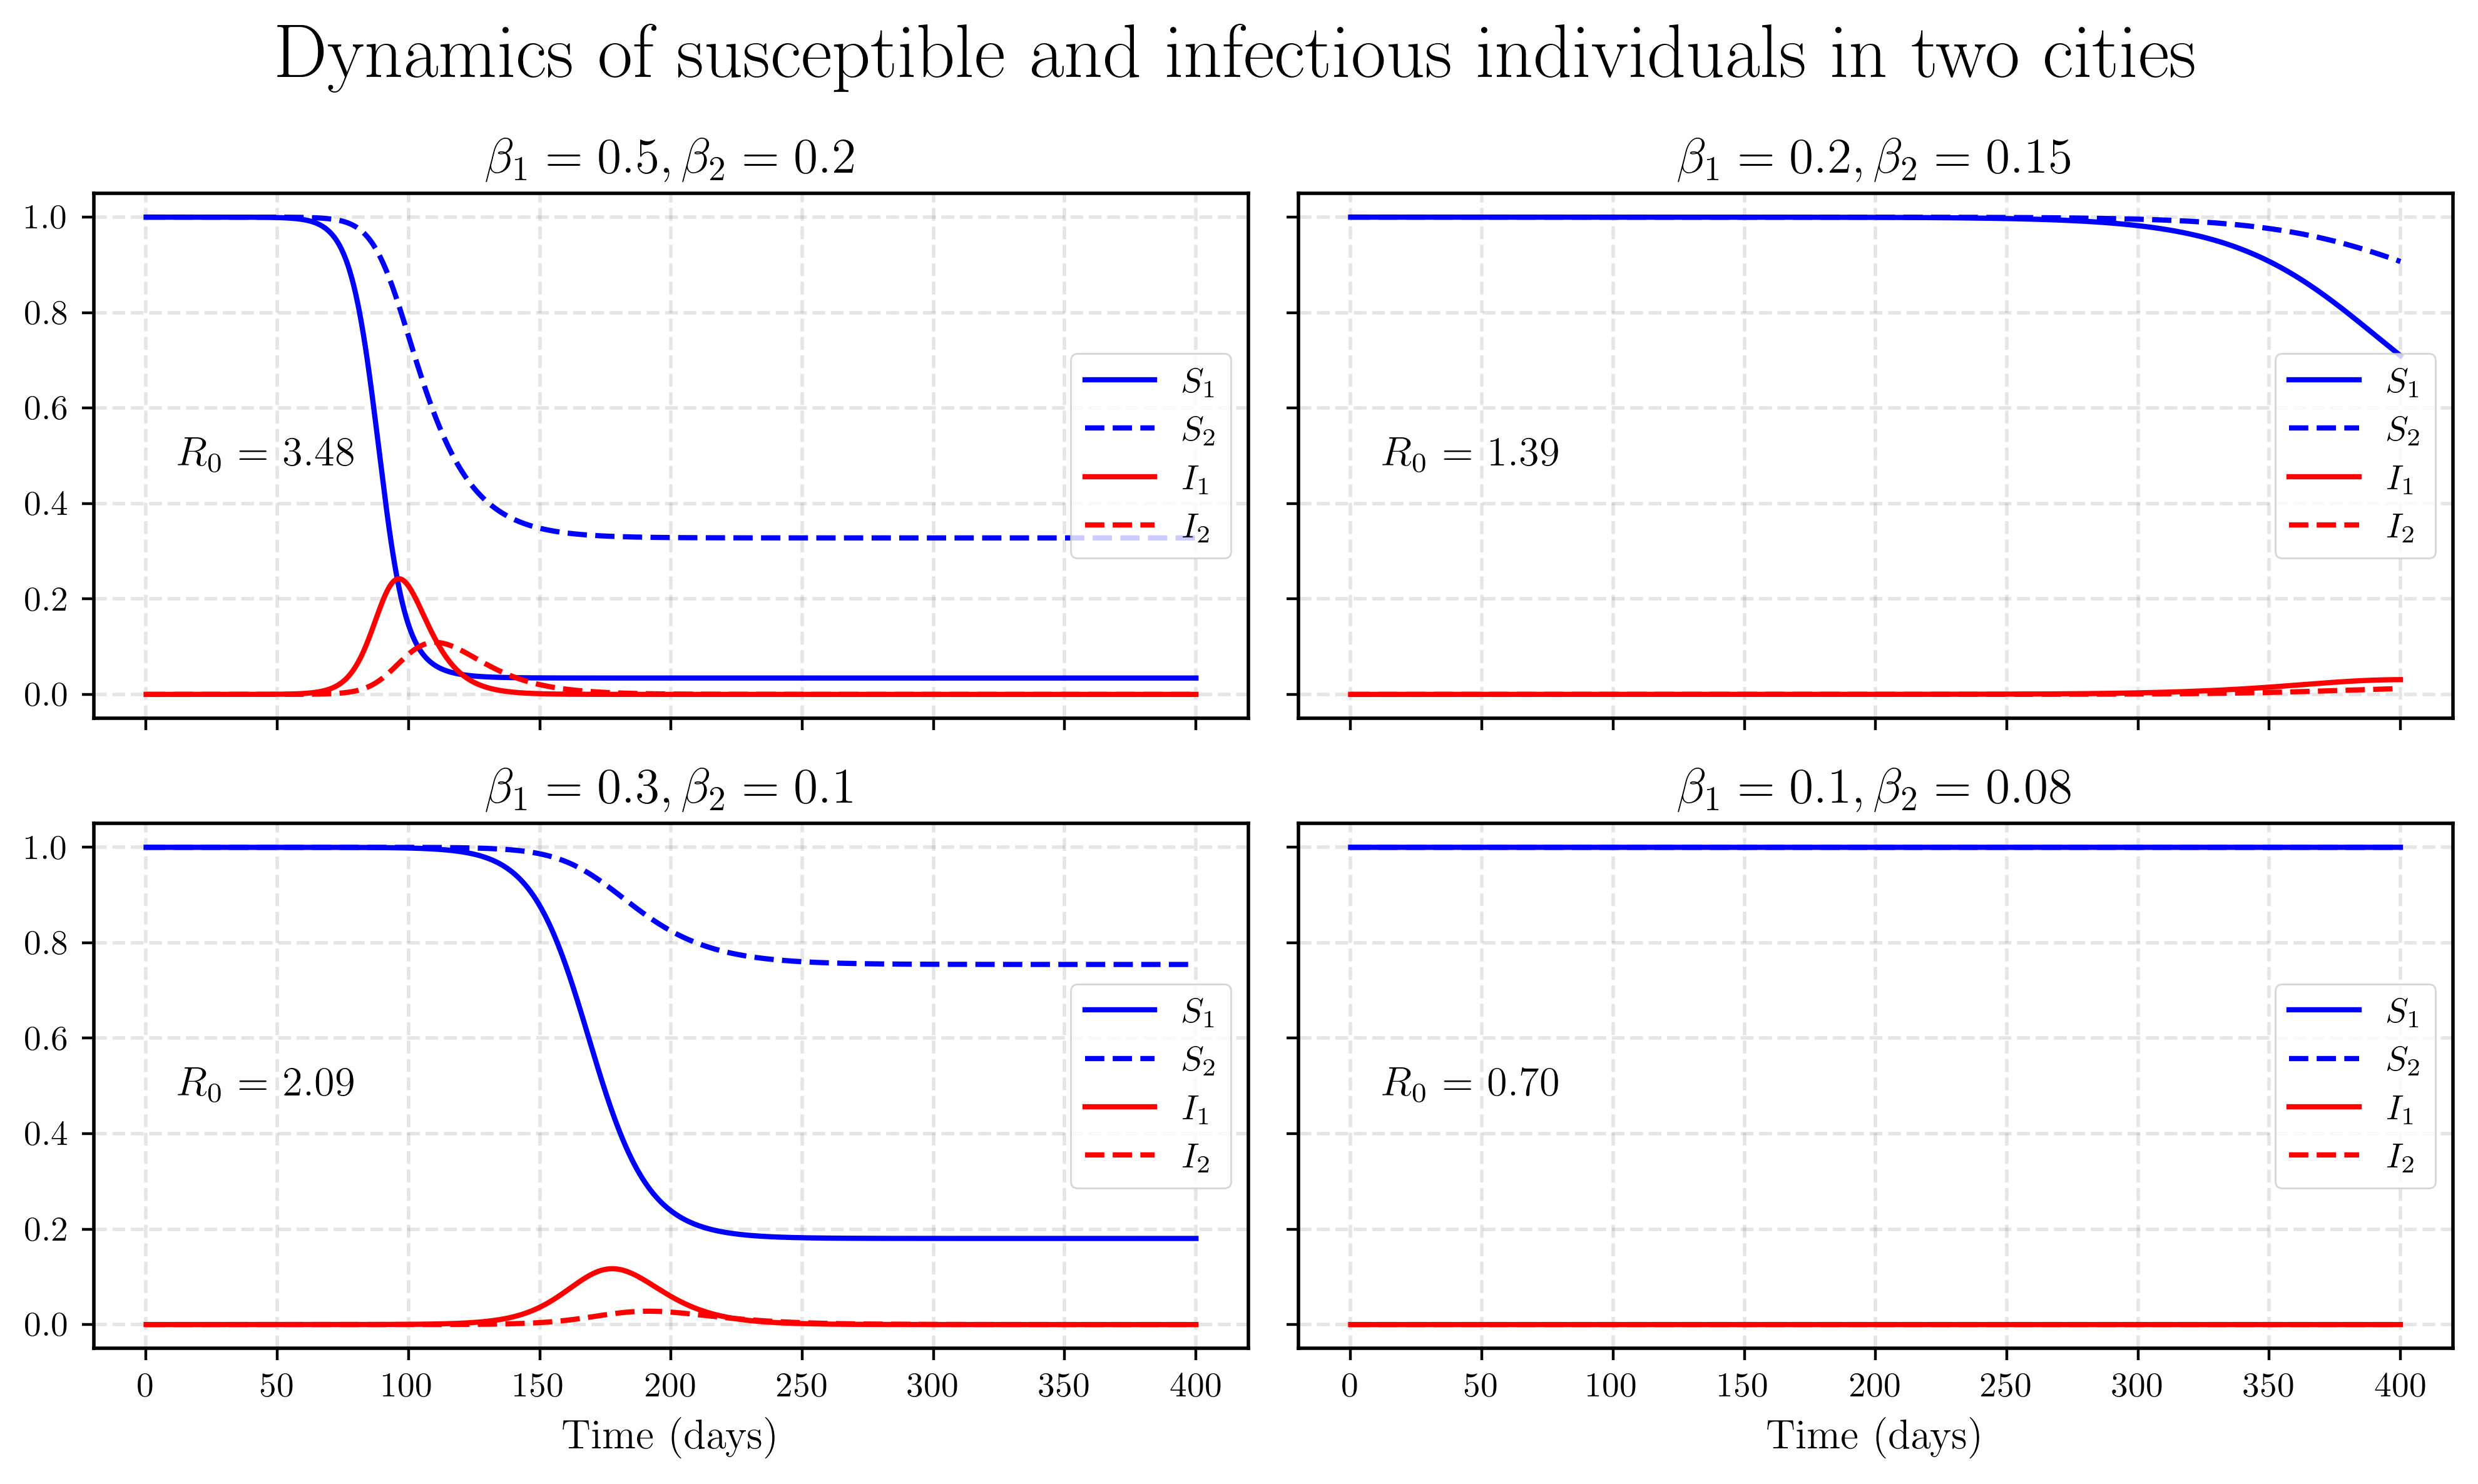

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)
axs = axs.ravel()  # Flatten the array of axes

for k in range(4):

    args = (alpha, betas[k], tau, gamma, K, p_matrix, population, population_eff)
    sol[k] = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                       t_span=(0,n_days),
                       y0=y0,
                       method='RK45',
                       t_eval=t_eval,
                       max_step=1e-2
                      )

    # Plot the solution on the k-th subplot
    axs[k].plot(sol[k].t, sol[k].y[0], label=r'$S_1$', color='blue', ls='-')
    axs[k].plot(sol[k].t, sol[k].y[1], label=r'$S_2$', color='blue', ls='--')
    axs[k].plot(sol[k].t, sol[k].y[4], label=r'$I_1$', color='red', ls='-')
    axs[k].plot(sol[k].t, sol[k].y[5], label=r'$I_2$', color='red', ls='--')
    axs[k].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    axs[k].set_title(f'$\\beta_1={betas[k][0]}, \\beta_2={betas[k][1]}$')  # Set the title for each subplot
    text = r'$R_0$ = {:.2f}'.format(calculate_r0(betas[k], tau, gamma, mu, alpha, population, p_matrix))
    axs[k].text(0.15, 0.5, text, horizontalalignment='center', verticalalignment='center', 
                transform=axs[k].transAxes, fontsize=12)  # Add text to each subplot

# Set the x-label for the last two subplots
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')

# Add a legend to each subplot
for ax in axs:
    ax.legend(loc='center right')
    
fig.suptitle('Dynamics of susceptible and infectious individuals in two cities', fontsize=22)

plt.tight_layout()
plt.savefig('../images/epidemic_behaviour_two_cities.pdf', bbox_inches='tight')
plt.show()

## K cities

We move to more general formulations.

In [29]:
# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
beta = np.array([0.5, 0.3, 0.25, 0.15, 0.1])
alpha = 0.64

# Population settings
x1 = 0.1
x2 = 0.4
population = 1e5*np.array([50, 10, 10, 1, 1])
p_matrices = [
    np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]]),
    np.array([[1,0,0,0,0],[x2,1-x2,0,0,0],[x2,0,1-x2,0,0],[x2,0,0,1-x2,0],[x2,0,0,0,1-x2]]),
    np.array([[2.4, 0.6, 0.6, 0.6, 0.6],[0.6, 2.4, 0.6, 0.6, 0.6],[0.6, 0.6, 2.4, 0.6, 0.6],
              [0.6, 0.6, 0.6, 2.4, 0.6],[0.6, 0.6, 0.6, 0.6, 2.4]])/4,
    np.eye(5)
]
population_eff_values = [population @ p_matrix for p_matrix in p_matrices]

# Initial condition
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 1e-4
y0[K+1] = 1e-4
y0[K+2] = 1e-4
y0[0:K] = 1-y0[K:2*K]

n_days = 350
t_eval = np.linspace(0, n_days, 100 * n_days)
sol = [0,0,0,0]

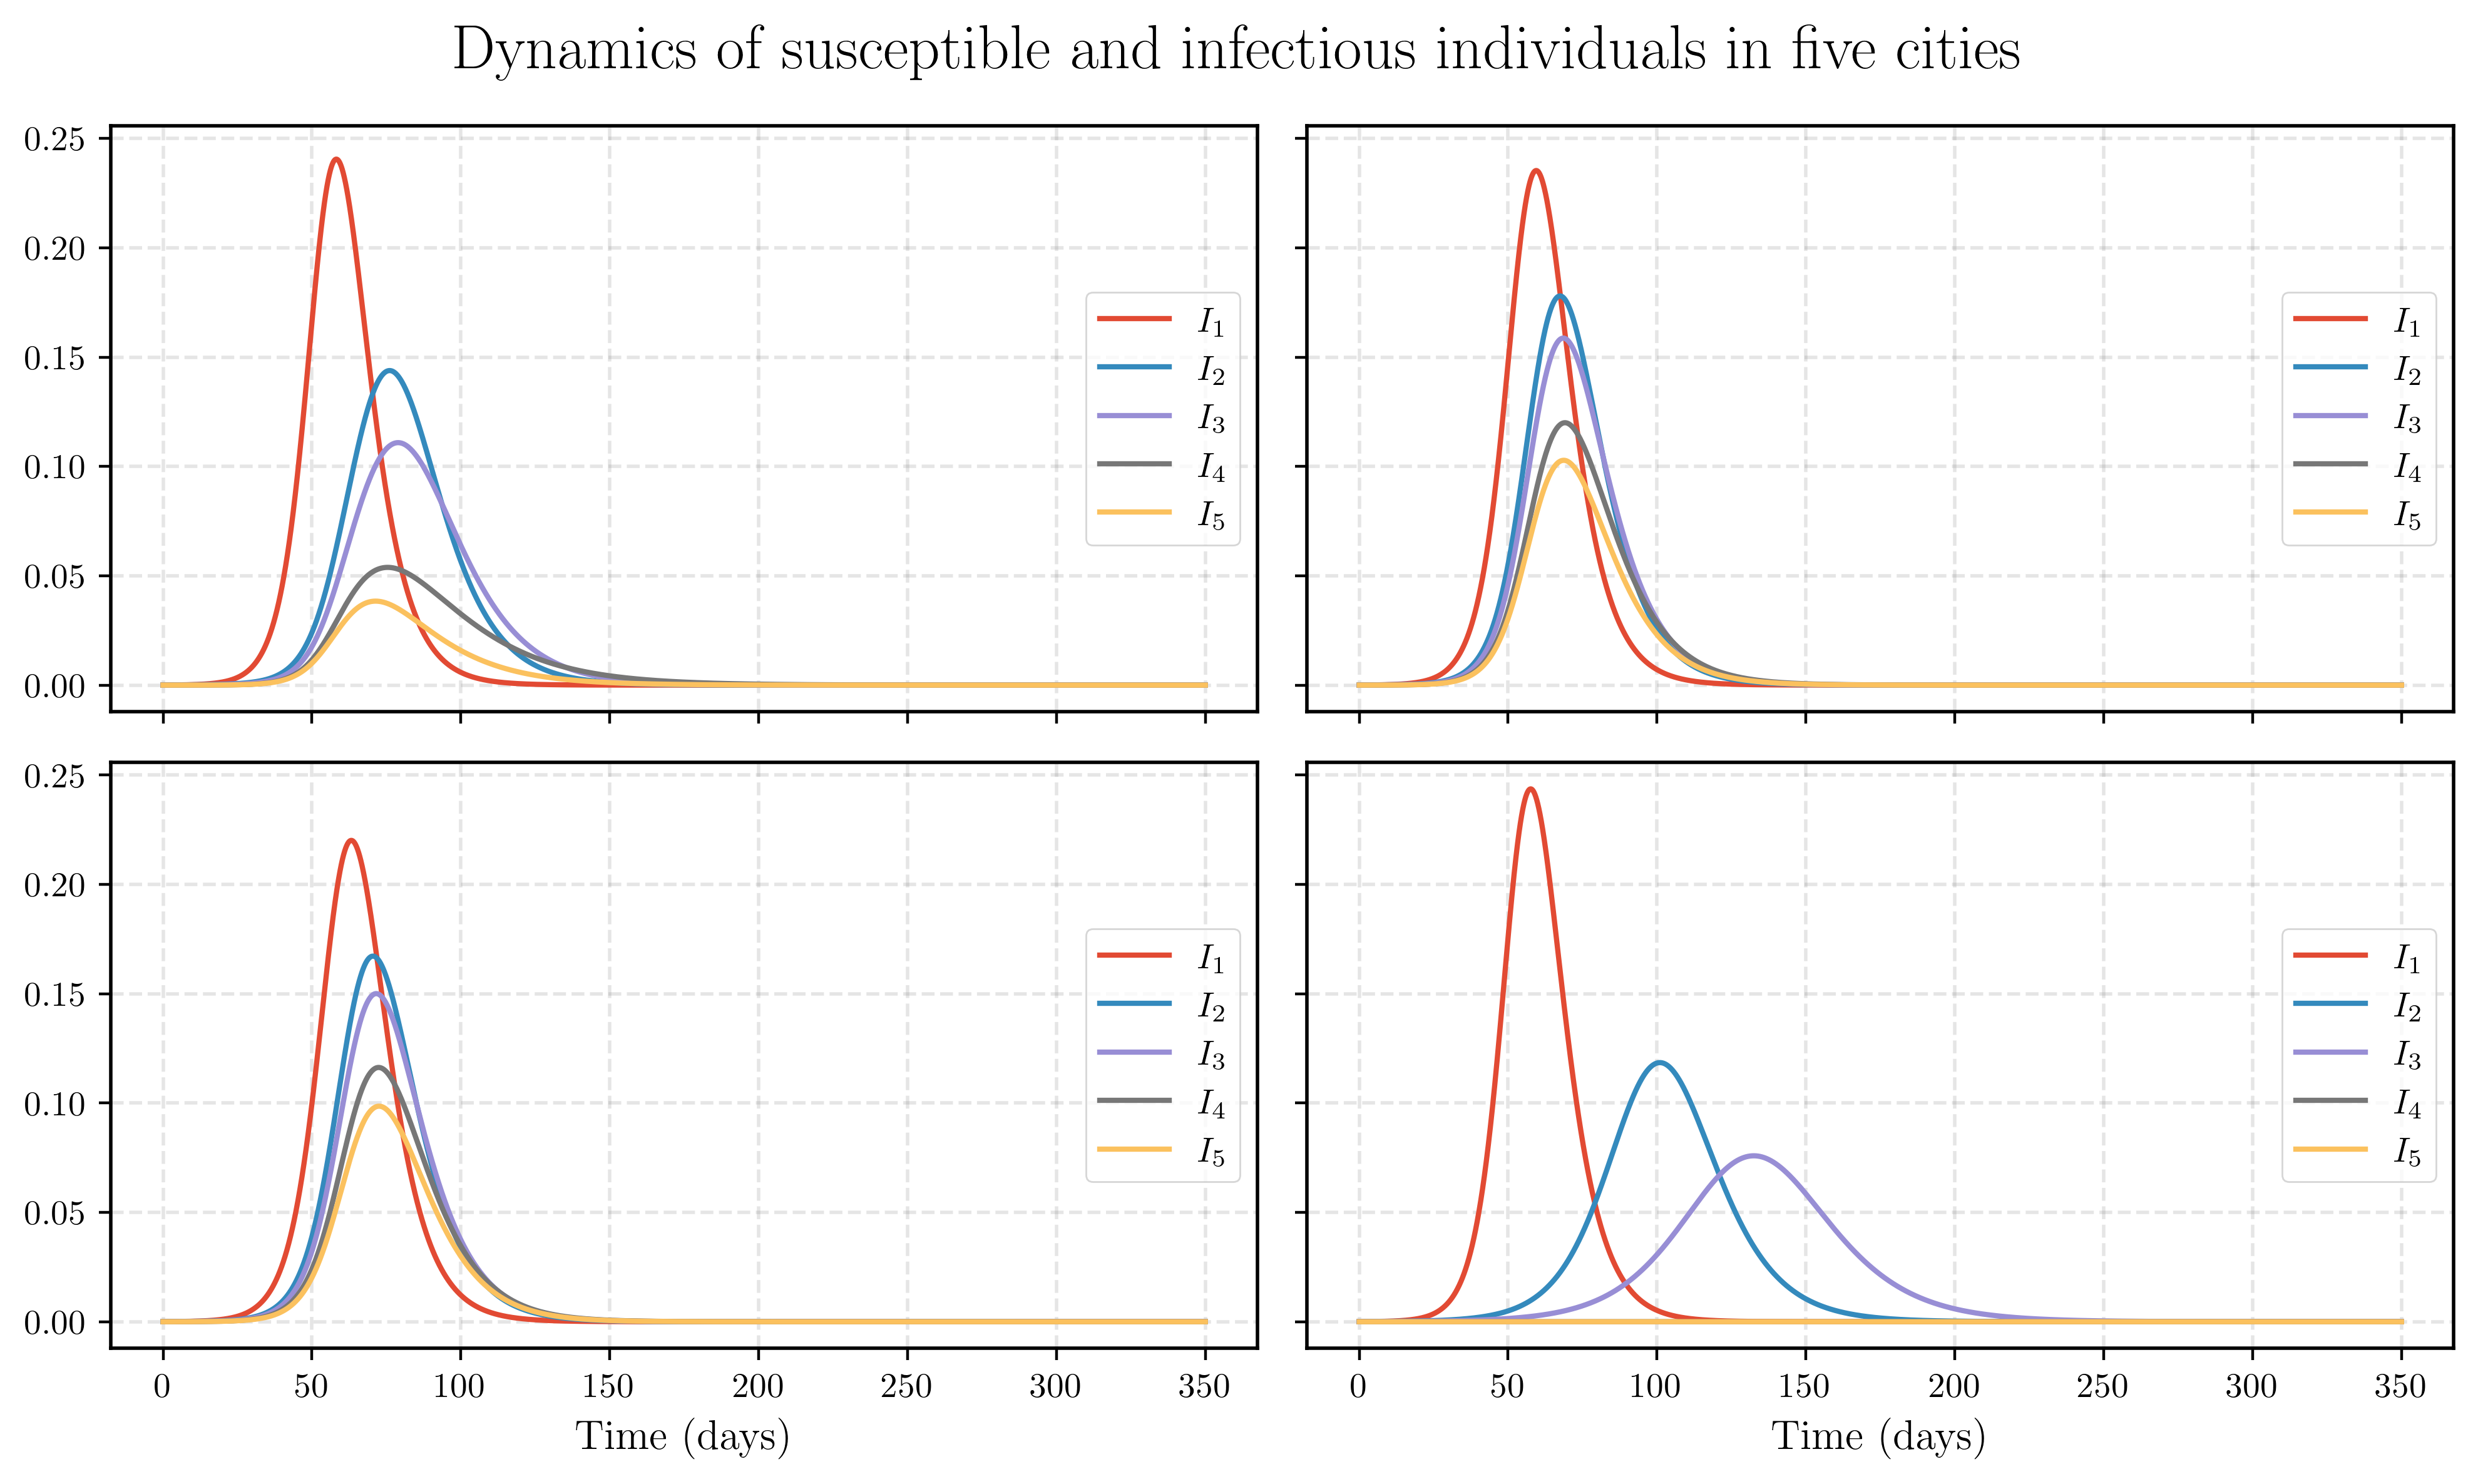

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)
axs = axs.ravel()  # Flatten the array of axes

for k in range(4):

    args = (alpha, beta, tau, gamma, K, p_matrices[k], population, population_eff_values[k])
    sol[k] = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                       t_span=(0,n_days),
                       y0=y0,
                       method='RK45',
                       t_eval=t_eval,
                       max_step=1e-2
                      )

    # Plot the solution on the k-th subplot
    for city in range(K):
        axs[k].plot(sol[k].t, sol[k].y[2*K+city], label=r'$I_{}$'.format(city+1))
    axs[k].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    #axs[k].set_title(f'$\\beta_1={betas[k][0]}, \\beta_2={betas[k][1]}$')  # Set the title for each subplot

# Set the x-label for the last two subplots
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')

# Add a legend to each subplot
for ax in axs:
    ax.legend(loc='center right')
    
fig.suptitle('Dynamics of susceptible and infectious individuals in five cities', fontsize=18)

plt.tight_layout()
#plt.savefig('../images/epidemic_behaviour_two_cities.pdf', bbox_inches='tight')
plt.show()

In [31]:
print("Peak size")
print("Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated")
for k in range(4):
    print("Scenario {} | {:.1f} | {:.1f} | {:.1f} | {:.1f} | {:.1f} | {:.1f}".format(k+1, 
                                                                                100*sol[k].y[2*K].max(), 
                                                                                100*sol[k].y[2*K+1].max(),
                                                                                100*sol[k].y[2*K+2].max(),
                                                                                100*sol[k].y[2*K+3].max(),
                                                                                100*sol[k].y[2*K+4].max(),
            100*(sol[k].y[2*K:2*K+5]*population.reshape(-1,1)).sum(axis=0).max()/population.sum()))

Peak size
Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated
Scenario 1 | 24.1 | 14.4 | 11.1 | 5.4 | 3.8 | 18.4
Scenario 2 | 23.5 | 17.8 | 15.9 | 12.0 | 10.3 | 20.4
Scenario 3 | 22.0 | 16.7 | 15.0 | 11.6 | 9.9 | 19.3
Scenario 4 | 24.4 | 11.8 | 7.6 | 0.0 | 0.0 | 17.1


In [32]:
print("Peak day")
print("Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated")
for k in range(4):
    print("Scenario {} | {} | {} | {} | {} | {} | {}".format(k+1, 
                                                             sol[k].y[2*K].argmax()/100, 
                                                             sol[k].y[2*K+1].argmax()/100,
                                                             sol[k].y[2*K+2].argmax()/100,
                                                             sol[k].y[2*K+3].argmax()/100,
                                                             sol[k].y[2*K+4].argmax()/100,
            (sol[k].y[2*K:2*K+5]*population.reshape(-1,1)).sum(axis=0).argmax()/100))

Peak day
Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated
Scenario 1 | 58.18 | 76.08 | 78.92 | 75.42 | 71.36 | 59.11
Scenario 2 | 59.42 | 67.43 | 68.51 | 69.09 | 68.66 | 60.83
Scenario 3 | 63.21 | 70.47 | 71.58 | 72.38 | 72.52 | 64.6
Scenario 4 | 57.57 | 100.97 | 132.5 | 0.0 | 0.0 | 57.65


In [33]:
print("Duration")
print("Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated")
for k in range(4):
    print("Scenario {} | {} | {} | {} | {} | {} | {}".format(k+1, 
                                                             np.ceil(350-np.argmax(sol[k].y[2*K][::-1] > 1e-5)/100), 
                                                             np.ceil(350-np.argmax(sol[k].y[2*K+1][::-1] > 1e-5)/100),
                                                             np.ceil(350-np.argmax(sol[k].y[2*K+2][::-1] > 1e-5)/100),
                                                             np.ceil(350-np.argmax(sol[k].y[2*K+3][::-1] > 1e-5)/100),
                                                             np.ceil(350-np.argmax(sol[k].y[2*K+4][::-1] > 1e-5)/100),
    np.ceil(350 - np.argmax((sol[k].y[2*K:2*K+5]*population.reshape(-1,1)).sum(axis=0)[::-1]/population.sum() > 1e-5)/100)))

Duration
Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated
Scenario 1 | 162.0 | 211.0 | 236.0 | 283.0 | 236.0 | 216.0
Scenario 2 | 162.0 | 186.0 | 194.0 | 201.0 | 195.0 | 179.0
Scenario 3 | 170.0 | 192.0 | 198.0 | 201.0 | 198.0 | 184.0
Scenario 4 | 154.0 | 245.0 | 314.0 | 350.0 | 350.0 | 279.0


In [34]:
print("Attack rate")
print("Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated")
for k in range(4):
    print("Scenario {} | {:.1f} | {:.1f} | {:.1f} | {:.1f} | {:.1f} | {:.1f}".format(k+1, 
                                                             100*(1-sol[k].y[0][-1]), 
                                                             100*(1-sol[k].y[1][-1]),
                                                             100*(1-sol[k].y[2][-1]),
                                                             100*(1-sol[k].y[3][-1]),
                                                             100*(1-sol[k].y[4][-1]),
          100*(1-(sol[k].y[0:5]*population.reshape(-1,1)).sum(axis=0)[-1]/population.sum())))

Attack rate
Scenarios  |  C1  |  C2  |  C3  |  C4  |  C5  | Aggregated
Scenario 1 | 96.6 | 83.7 | 75.0 | 42.1 | 25.2 | 90.0
Scenario 2 | 96.5 | 87.0 | 81.7 | 65.5 | 55.4 | 92.1
Scenario 3 | 95.6 | 84.9 | 79.5 | 64.4 | 54.7 | 90.9
Scenario 4 | 96.6 | 82.2 | 71.3 | 0.0 | 0.0 | 88.4


### The impact of the parameter $\alpha$

In [35]:
# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
beta = np.array([0.5, 0.3, 0.25, 0.15, 0.1])
alpha = 0.64

# Population settings
population = 1e5*np.array([50, 10, 10, 1, 1])
x1 = 0.2
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = population @ p_matrix

# Initial condition
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 1e-4
y0[K+1] = 1e-4
y0[K+2] = 1e-4
y0[0:K] = 1-y0[K:2*K]

n_days = 200
t_eval = np.linspace(0, n_days, 50 * n_days)
sol = []

alpha_values = np.linspace(0,1,20)

for k, alpha in enumerate(alpha_values):

    args = (alpha, beta, tau, gamma, K, p_matrix, population, population_eff)
    sol.append(solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                       t_span=(0,n_days),
                       y0=y0,
                       method='RK45',
                       t_eval=t_eval,
                       max_step=1e-2
                      ))

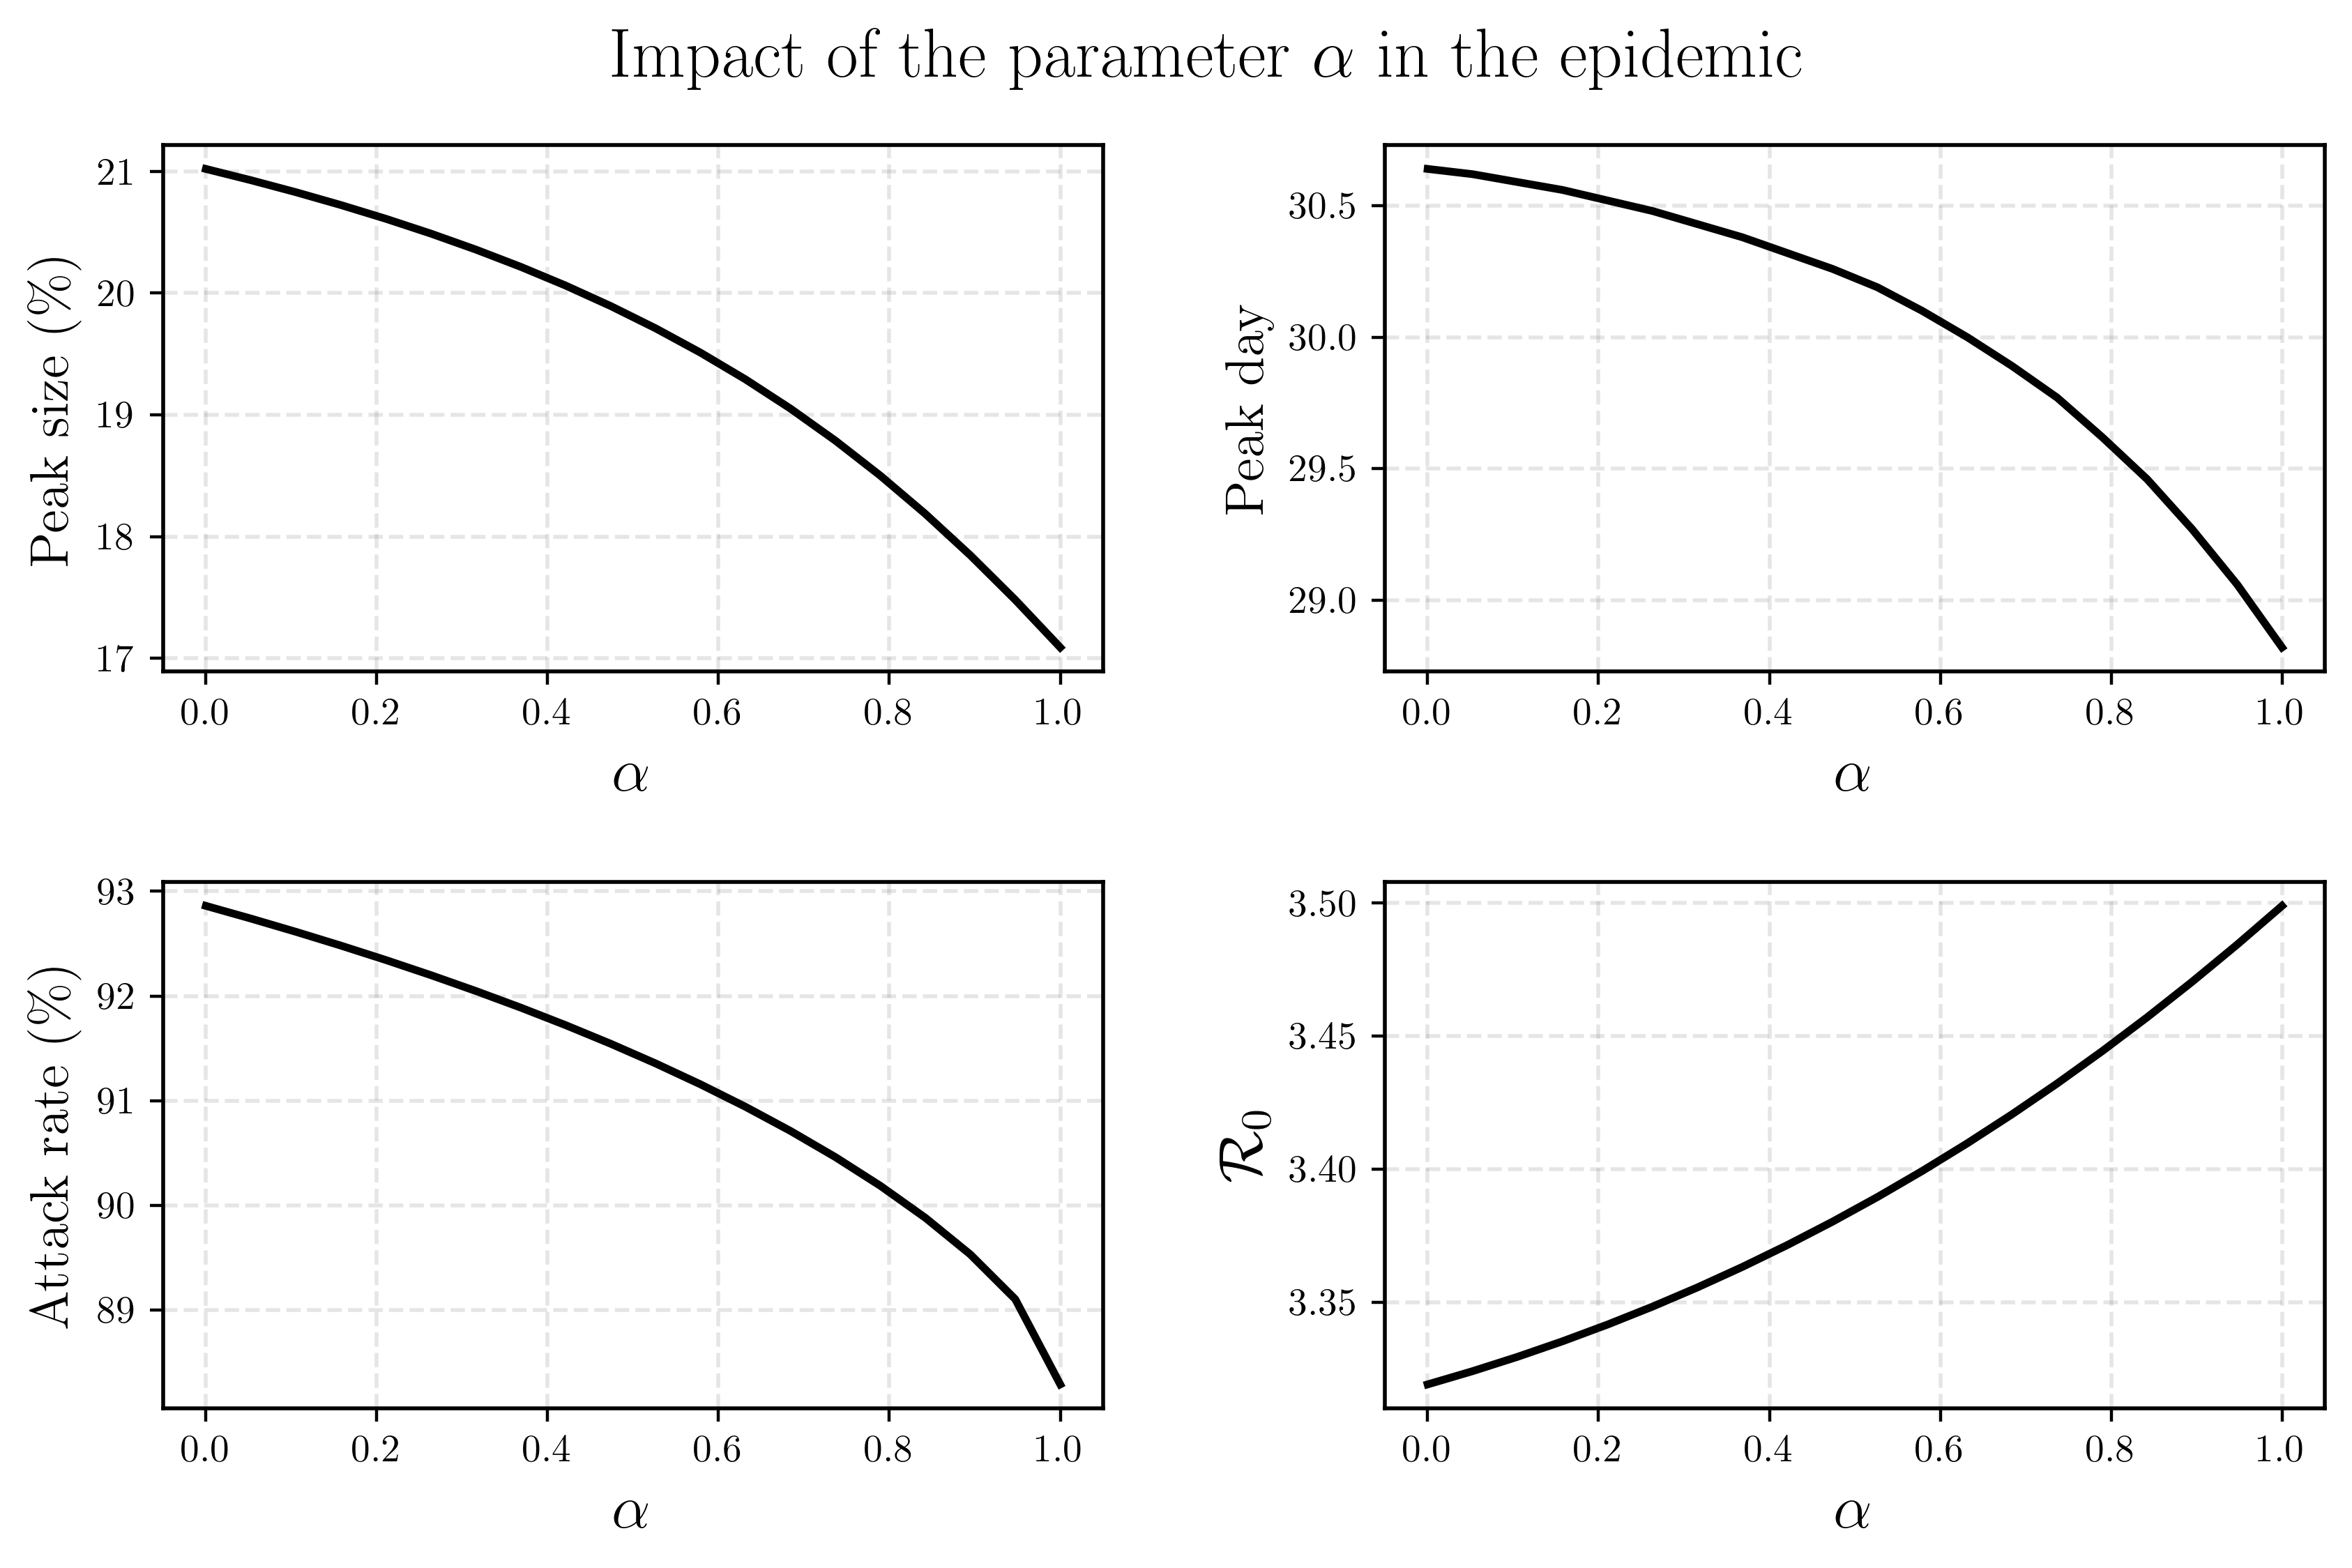

In [40]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

ax[0,0].plot(alpha_values, 
           [100*(k.y[2*K:2*K+K]*population.reshape(-1,1)).sum(axis=0).max()/population.sum() for k in sol],
           lw=2, c='black')
ax[0,0].set_ylabel('Peak size (\%)', fontsize=14)
ax[0,1].plot(alpha_values,
           [(k.y[2*K:2*K+K]*population.reshape(-1,1)).sum(axis=0).argmax()/100 for k in sol],
           lw=2, c='black')
ax[0,1].set_ylabel('Peak day', fontsize=14)
ax[1,0].plot(alpha_values,
           [100*(1-(k.y[0:K]*population.reshape(-1,1)).sum(axis=0)[-1]/population.sum()) for k in sol],
           lw=2, c='black')
ax[1,0].set_ylabel('Attack rate (\%)', fontsize=14)
ax[1,1].plot(alpha_values,
           [calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix) for alpha in alpha_values],
           lw=2, c='black')
ax[1,1].set_ylabel(r'$\mathcal{R}_0$', fontsize=16)

for i in range(2):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
        ax[i,j].set_xlabel(r'$\alpha$', fontsize=16)
        
fig.suptitle(r'Impact of the parameter $\alpha$ in the epidemic', fontsize=18, y=0.95)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig('../images/impact_alpha_epidemic.pdf', bbox_inches='tight')
plt.show()

### The impact of the parameter $\beta$. 

In [41]:
# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
alpha = 0.64

# Population settings
population = 1e5*np.array([50, 10, 10, 1, 1])
x1 = 0.2
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = population @ p_matrix

# Initial condition
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 1e-4
y0[K+1] = 1e-4
y0[K+2] = 1e-4
y0[0:K] = 1-y0[K:2*K]

n_days = 1400 // 7
t_eval = np.linspace(0, n_days, 50 * n_days)
sol = []

beta_values = [
    np.array([0.2, 0.1, 0.1, 0.1, 0.1]),
    np.array([0.15, 0.1, 0.1, 0.1, 0.1]),
    np.array([0.1, 0.1, 0.15, 0.1, 0.1]),
    np.array([0.2, 0.2, 0.2, 0.2, 0.2])
]

for k, beta in enumerate(beta_values):

    args = (alpha, 7*beta, 7*tau, 7*gamma, K, p_matrix, population, population_eff)
    sol.append(solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                       t_span=(0,n_days),
                       y0=y0,
                       method='RK45',
                       t_eval=t_eval,
                       max_step=1e-2
                      ))

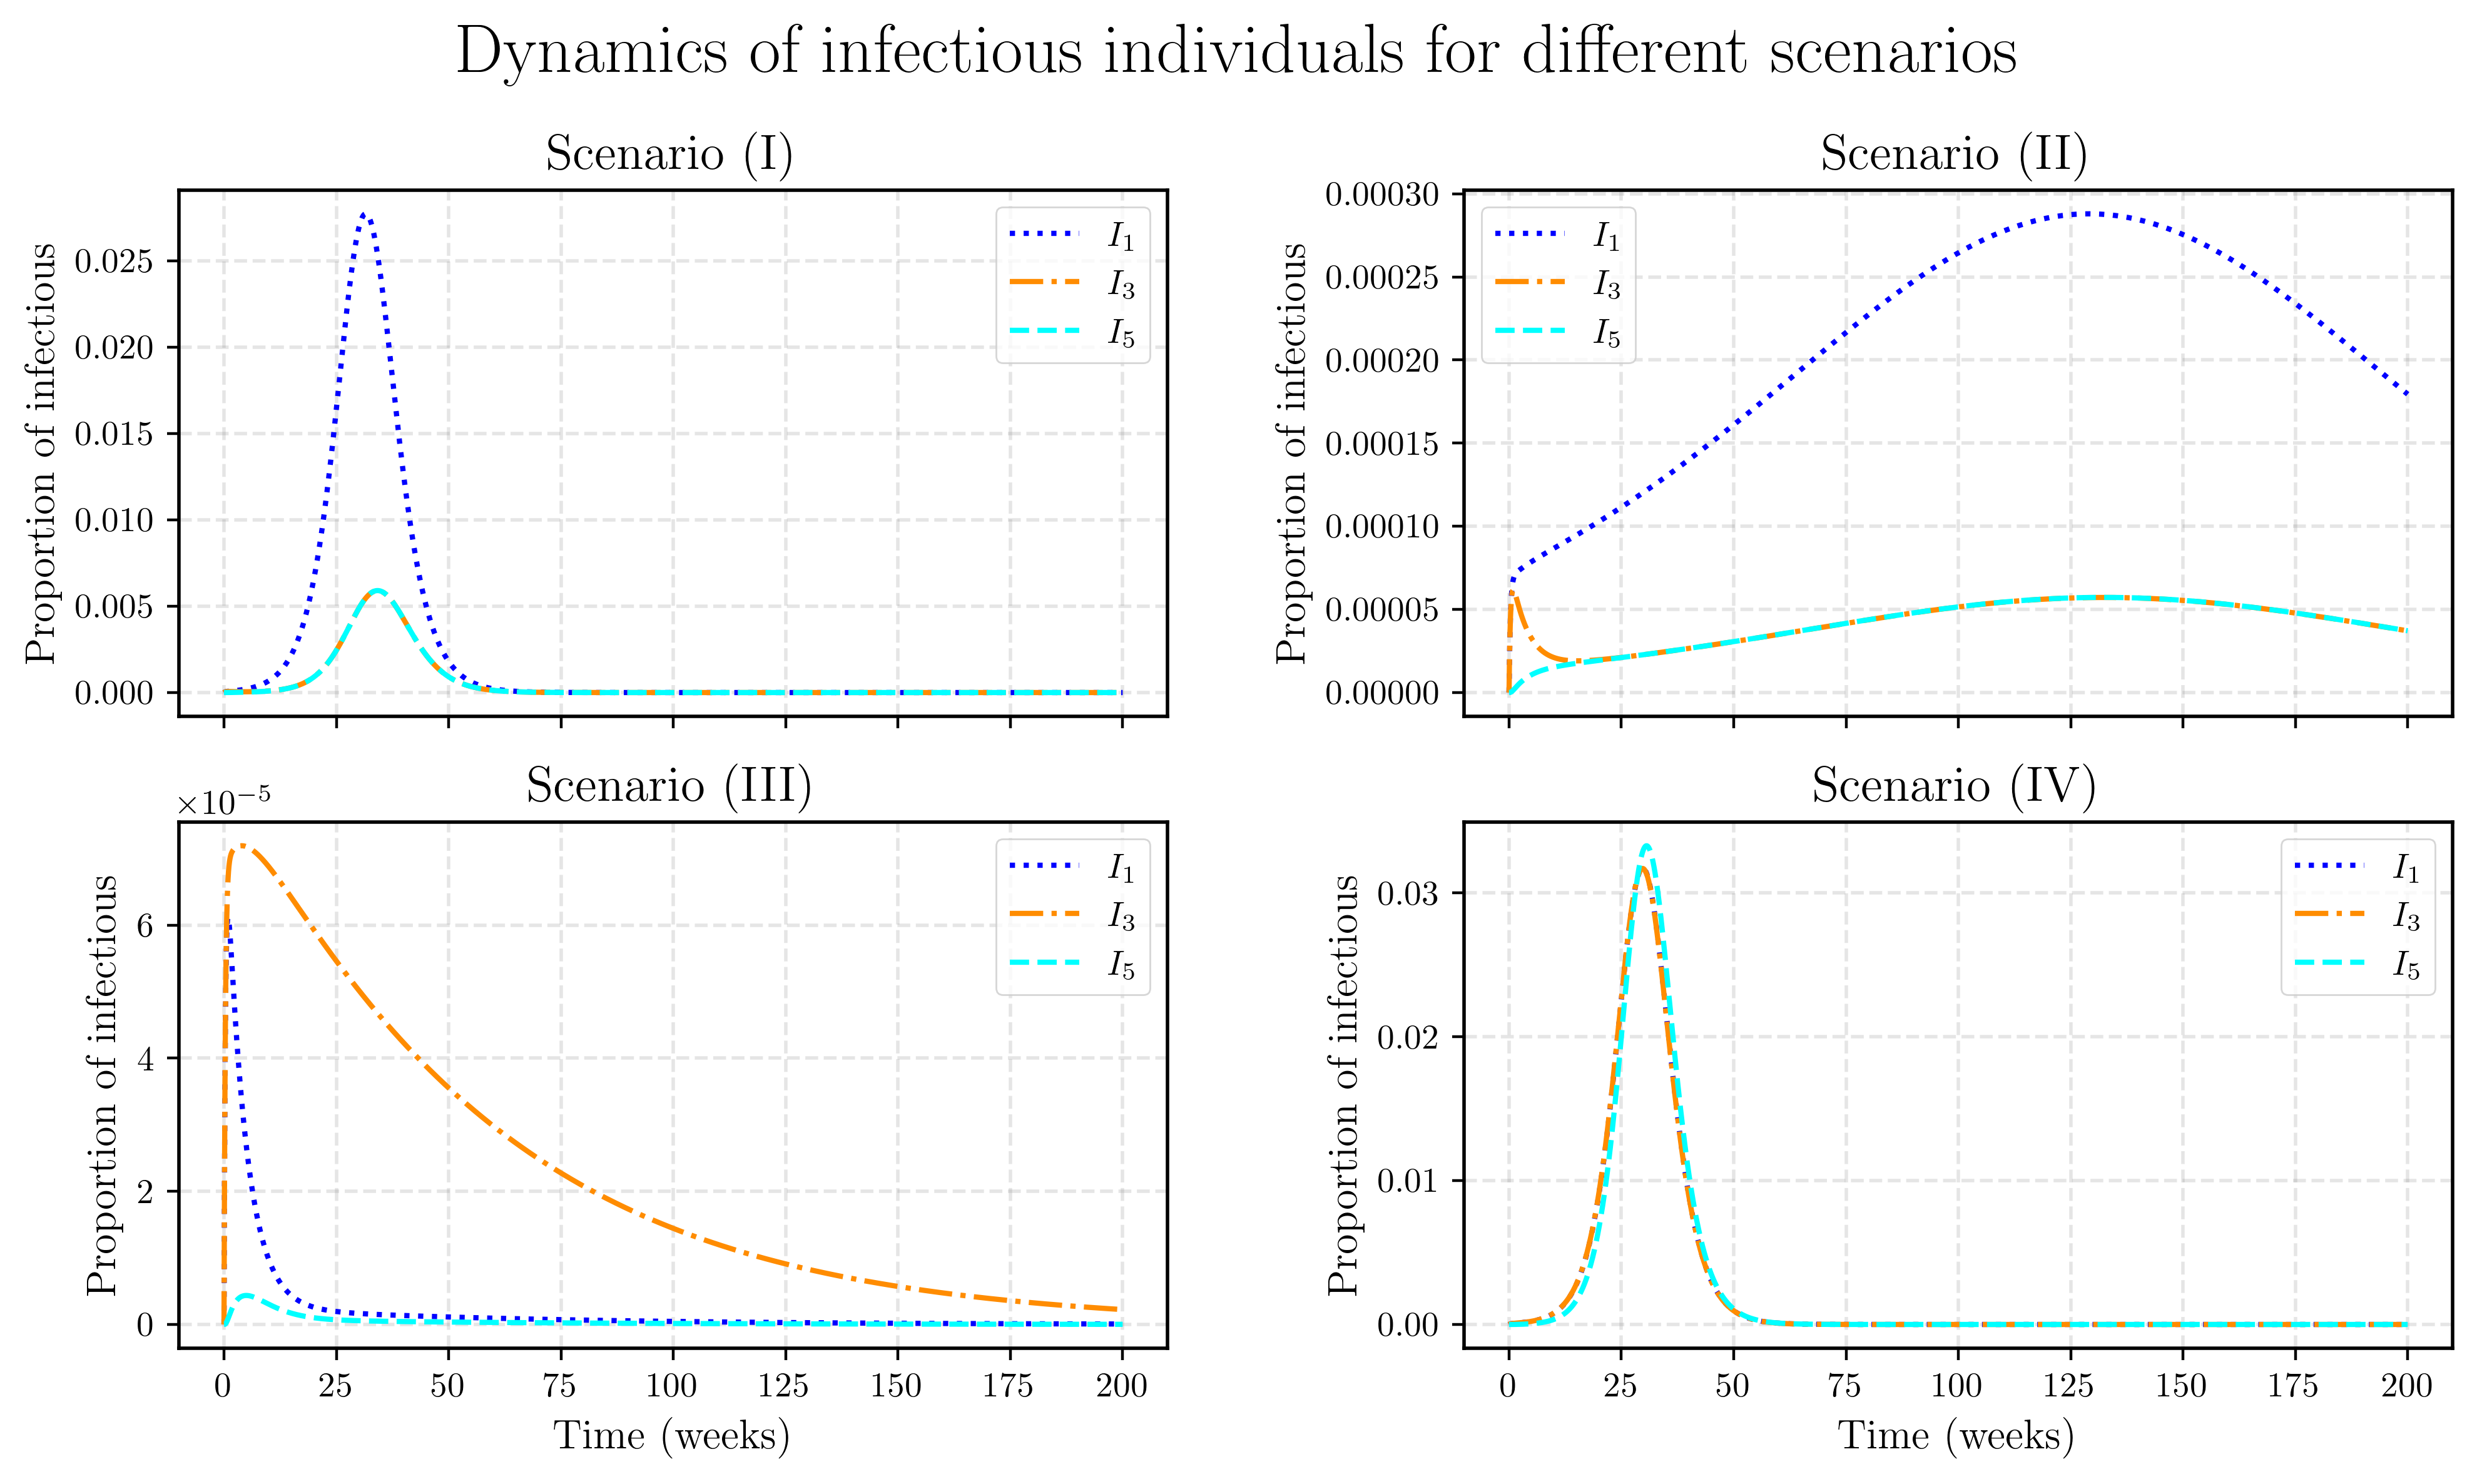

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
axs = axs.ravel()  # Flatten the array of axes

colors = ['blue', 'black', 'darkorange', 'gray', 'cyan']
linestyles = [':', '--', '-.', '-', '--']

for k in range(4):
    for city in range(0,5,2):  # Assuming K=5
        axs[k].plot(sol[k].t, sol[k].y[2*K+city], color=colors[city], linestyle=linestyles[city], 
                    label=r'$I_{}$'.format(city+1))
    axs[k].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    axs[k].set_title('Scenario ({})'.format(['I', 'II', 'III', 'IV'][k]))
    #axs[k].set_title(f'$\\beta=({beta_values[k][0]}, {beta_values[k][1]}, \
    #                            {beta_values[k][2]}, {beta_values[k][3]}, {beta_values[k][4]})$')
    axs[k].set_ylabel('Proportion of infectious')

# Set the x-label for the last two subplots
axs[2].set_xlabel('Time (weeks)')
axs[3].set_xlabel('Time (weeks)')

# Add a legend to each subplot
for ax in axs:
    ax.legend(loc='best')
    
fig.suptitle('Dynamics of infectious individuals for different scenarios', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.3)
plt.savefig('../images/dynamics_infectious_different_beta_values.pdf', bbox_inches='tight')
plt.show()

In [45]:
ro = np.random.RandomState(9120312)

# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
alpha = 0.64

# Population settings
population = 1e6*np.array([5, 1, 1, 1, 1])
x1 = 0.2
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = population @ p_matrix

# Initial condition
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 1e-4
y0[K+1] = 1e-4
y0[K+2] = 1e-4
y0[0:K] = 1-y0[K:2*K]

n_days = 140 // 7
t_eval = np.linspace(0, n_days, 50 * n_days)
sol = []

size = 200
beta_values = np.vstack([ro.uniform(0.15, 0.4, size), 
                         ro.uniform(0.1, 0.2, size),
                         ro.uniform(0.07, 0.15, size),
                         ro.uniform(0.03, 0.1, size),
                         ro.uniform(0.0, 0.05, size)]).T

for k, beta in enumerate(beta_values):

    args = (alpha, 7*beta, 7*tau, 7*gamma, K, p_matrix, population, population_eff)
    sol.append(solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                       t_span=(0,n_days),
                       y0=y0,
                       method='RK45',
                       t_eval=t_eval,
                       max_step=1e-2
                      ))

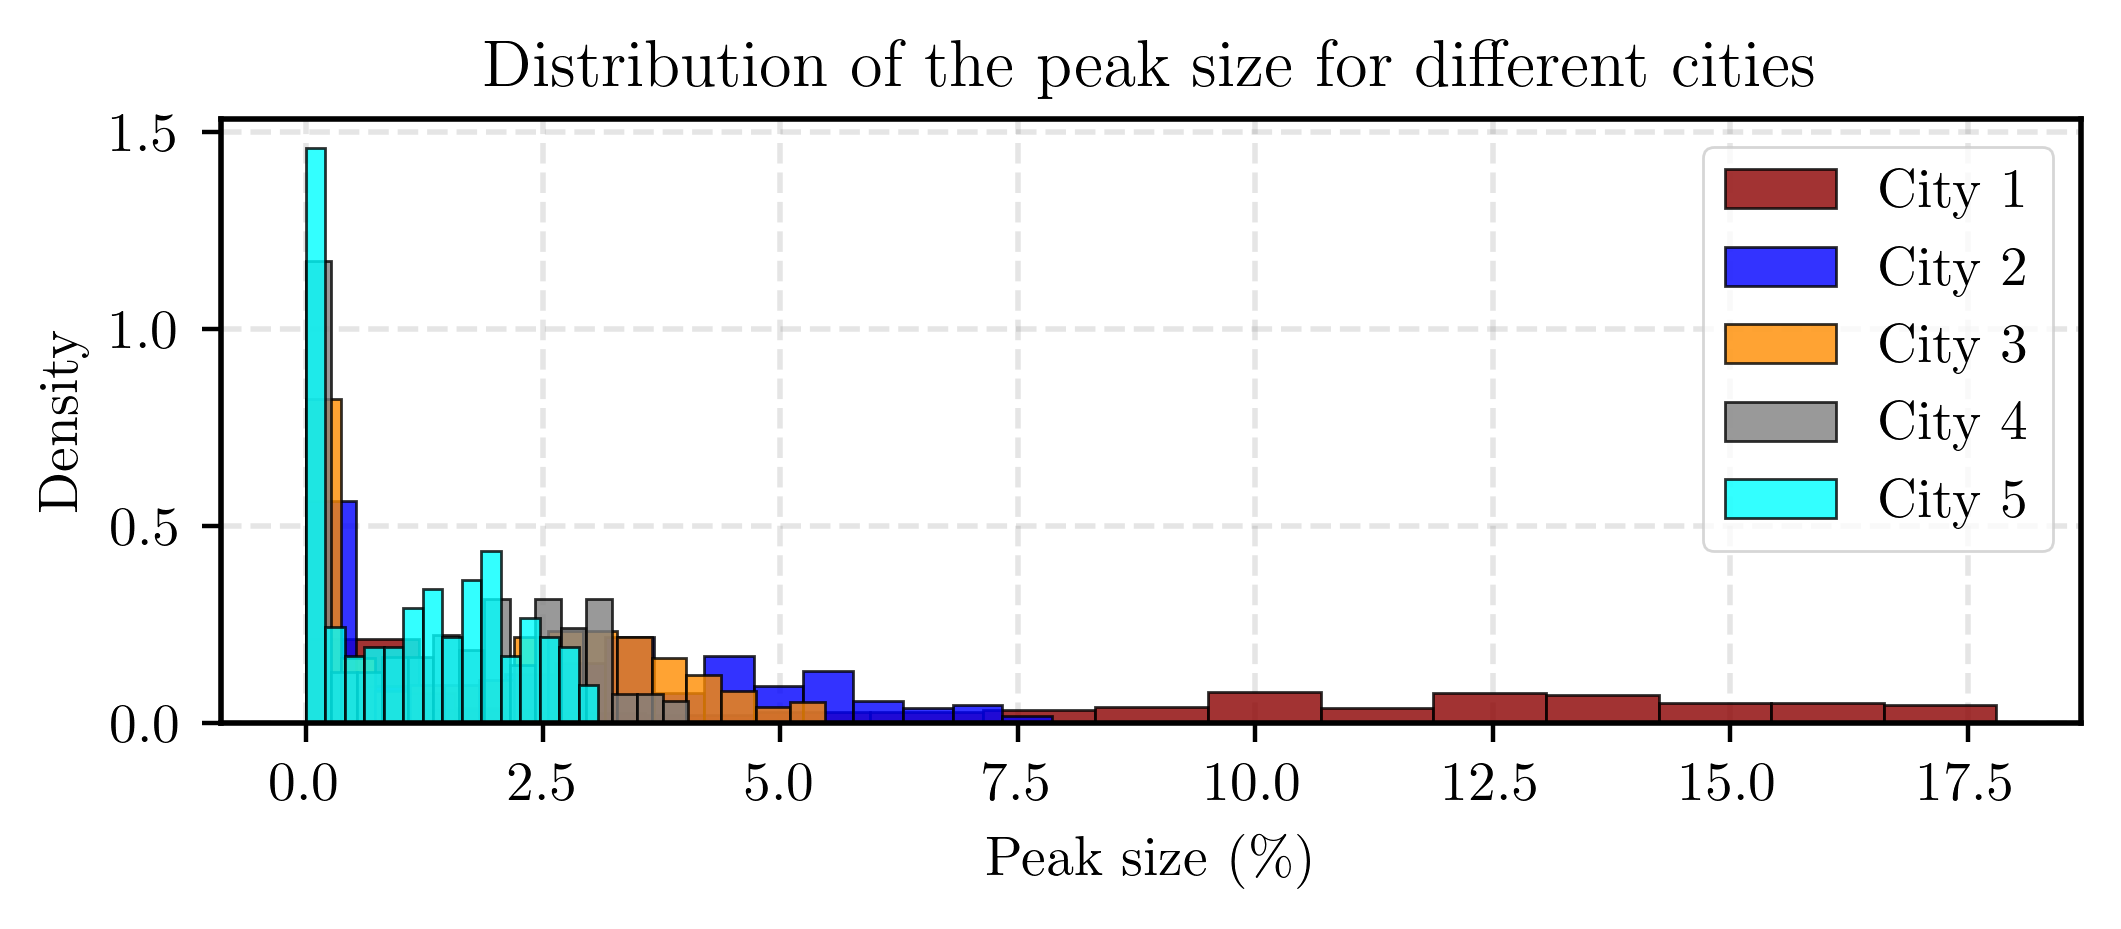

In [62]:
colors = ['darkred', 'blue', 'darkorange', 'gray', 'cyan']

plt.figure(figsize=(6,2))
for city in range(K):
    plt.hist([100*k.y[2*K+city].max() for k in sol], density=True, ec='black', label='City {}'.format(city+1), bins=15,
             alpha=0.8, color=colors[city])
plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
plt.xlabel('Peak size (\%)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.title('Distribution of the peak size for different cities', fontsize=12)
plt.legend(fancybox=True)
plt.savefig('../images/distribution_peak_size_betas.pdf', bbox_inches='tight')
plt.show()

### Analysing the bounds for K cities

In [387]:
ro = np.random.RandomState(seed=83921001)

# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5

N = 500000
r0_values = np.zeros(N)
lb_values = np.zeros_like(r0_values)
ub_values = np.zeros_like(r0_values)
lb_values_met = np.zeros_like(r0_values)
ub_values_met = np.zeros_like(r0_values)
lb_better = np.zeros_like(r0_values)
ub_better = np.zeros_like(r0_values)

for i in range(N):

    beta = np.array([ro.uniform(0.15, 0.4), 
                     ro.uniform(0.1, 0.2),
                     ro.uniform(0.07, 0.15),
                     ro.uniform(0.03, 0.1),
                     ro.uniform(0.0, 0.05)])
    alpha = ro.uniform(0.0, 1)
    p_values = ro.uniform(0,0.9,size=5)

    # Population settings
    population = np.sort(ro.randint(1, 50, K))[::-1]
    p_matrix = np.diag(1-p_values)
    p_matrix[:,0] = p_values
    p_matrix[0,0] = 1.0   
    
    r0_values[i] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)
    lb_values[i], ub_values[i] = calculate_bounds(alpha, beta, p_matrix)
    lb_values_met[i], ub_values_met[i] = calculate_bounds_metropolitan(alpha, beta, p_matrix, population)
    
    lb_better[i] = 1*(lb_values[i] > lb_values_met[i])
    ub_better[i] = 1*(ub_values[i] < ub_values_met[i])

In [388]:
print("Metropolitan has better bounds: {:.1f}%".format(100*np.mean((1-ub_better)*(1-lb_better))))
print("Metropolitan has only better upper bound: {:.1f}%".format(100*np.mean((1-ub_better)*lb_better)))
print("Metropolitan has only better lower bound: {:.1f}%".format(100*np.mean(ub_better*(1-lb_better))))
print("Metropolitan has worst bounds: {:.1f}%".format(100*np.mean(ub_better*lb_better)))

Metropolitan has better bounds: 48.9%
Metropolitan has only better upper bound: 1.3%
Metropolitan has only better lower bound: 46.0%
Metropolitan has worst bounds: 3.8%


In [389]:
ro = np.random.RandomState(seed=83921001)

# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5

N = 500000
r0_values = np.zeros(N)
lb_values = np.zeros_like(r0_values)
ub_values = np.zeros_like(r0_values)
lb_values_met = np.zeros_like(r0_values)
ub_values_met = np.zeros_like(r0_values)
lb_better = np.zeros_like(r0_values)
ub_better = np.zeros_like(r0_values)

for i in range(N):

    beta = np.array([ro.uniform(0.15, 0.4), 
                     ro.uniform(0.1, 0.2),
                     ro.uniform(0.07, 0.15),
                     ro.uniform(0.03, 0.1),
                     ro.uniform(0.0, 0.05)])
    alpha = ro.uniform(0.5, 1)
    p_values = ro.uniform(0,0.9,size=5)

    # Population settings
    population = np.sort(ro.randint(1, 50, K))[::-1]
    p_matrix = np.diag(1-p_values)
    p_matrix[:,0] = p_values
    p_matrix[0,0] = 1.0   
    
    r0_values[i] = calculate_r0(beta, tau, gamma, mu, alpha, population, p_matrix)
    lb_values[i], ub_values[i] = calculate_bounds(alpha, beta, p_matrix)
    lb_values_met[i], ub_values_met[i] = calculate_bounds_metropolitan(alpha, beta, p_matrix, population)
    
    lb_better[i] = 1*(lb_values[i] > lb_values_met[i])
    ub_better[i] = 1*(ub_values[i] < ub_values_met[i])

In [390]:
print("Metropolitan has better bounds: {:.1f}%".format(100*np.mean((1-ub_better)*(1-lb_better))))
print("Metropolitan has only better upper bound: {:.1f}%".format(100*np.mean((1-ub_better)*lb_better)))
print("Metropolitan has only better lower bound: {:.1f}%".format(100*np.mean(ub_better*(1-lb_better))))
print("Metropolitan has worst bounds: {:.1f}%".format(100*np.mean(ub_better*lb_better)))

Metropolitan has better bounds: 80.6%
Metropolitan has only better upper bound: 0.0%
Metropolitan has only better lower bound: 19.4%
Metropolitan has worst bounds: 0.0%


## The basic reproduction number

Here we provide the code to calculate the basic reproduction number.

In [63]:
# Experimental setup
alpha = 0.5
beta = np.array([0.9, 0.8, 0.7])  # Infection rates for each city
p = np.array([[0.2, 0.3, 0.5], [0.4, 0.1, 0.5], [0.3, 0.4, 0.3]])  # Transition probabilities between cities
population_sizes = np.array([1e6, 1e5, 5e4])

# Parameters
tau = 0.2  # Transmission rate
gamma = 0.1  # Recovery rate
mu = 1e-10  # Birth and death rate

# Calculate R0 and bounds
r0 = calculate_r0(beta, tau, gamma, mu, alpha, population_sizes, p)
min_bound, max_bound = calculate_bounds(alpha, beta, p)

# Print the results
print("Basic Reproduction Number (R0):", r0)
print("Lower Bound:", min_bound)
print("Upper Bound:", max_bound)

Basic Reproduction Number (R0): 8.287211592738336
Lower Bound: 7.499999988749999
Upper Bound: 8.349999987474998


In [65]:
# Random object
ro = np.random.RandomState(seed=92100)

# Define the number of samples
num_samples = 10000

# Define the fixed parameters
tau = 0.1
mu = 1e-6
gamma = 0.3
K = 5
population_sizes = np.array([1e6, 1e5, 1e5, 8e4, 6e4])

# Sample from the parameters
beta_samples = ro.uniform(0.2, 1, (num_samples, K))
alpha_samples = ro.uniform(0, 1, num_samples)
alpha_samples_red = 0.5*np.ones(num_samples)#
p_samples = ro.uniform(0, 1, (num_samples, K, K))

# Calculate r0, upper bound, and lower bound for each sample
r0_values = np.zeros(num_samples)
ub_values = np.zeros_like(r0_values)
lb_values = np.zeros_like(r0_values)

r0_values_red = np.zeros(num_samples)
ub_values_red = np.zeros_like(r0_values_red)
lb_values_red = np.zeros_like(r0_values_red)

for i in range(num_samples):
    p = p_samples[i]/p_samples[i].sum(axis=1)
    r0_values[i] = calculate_r0(np.sort(beta_samples[i])[::-1], tau, gamma, mu, alpha_samples[i], population_sizes, p)
    lb_values[i], ub_values[i] = calculate_bounds(alpha_samples[i], np.sort(beta_samples[i])[::-1], p)
    
    r0_values_red[i] = calculate_r0(np.sort(beta_samples[i])[::-1], tau, gamma, mu, alpha_samples_red[i], population_sizes, p)
    lb_values_red[i], ub_values_red[i] = calculate_bounds(alpha_samples_red[i], np.sort(beta_samples[i])[::-1], p)

# Calculate the differences from r0
upper_bound_diff = (ub_values - r0_values)/r0_values
lower_bound_diff = (r0_values - lb_values)/r0_values

# Calculate the differences from r0
upper_bound_diff_red = (ub_values_red - r0_values_red)/r0_values_red
lower_bound_diff_red = (r0_values_red - lb_values_red)/r0_values_red

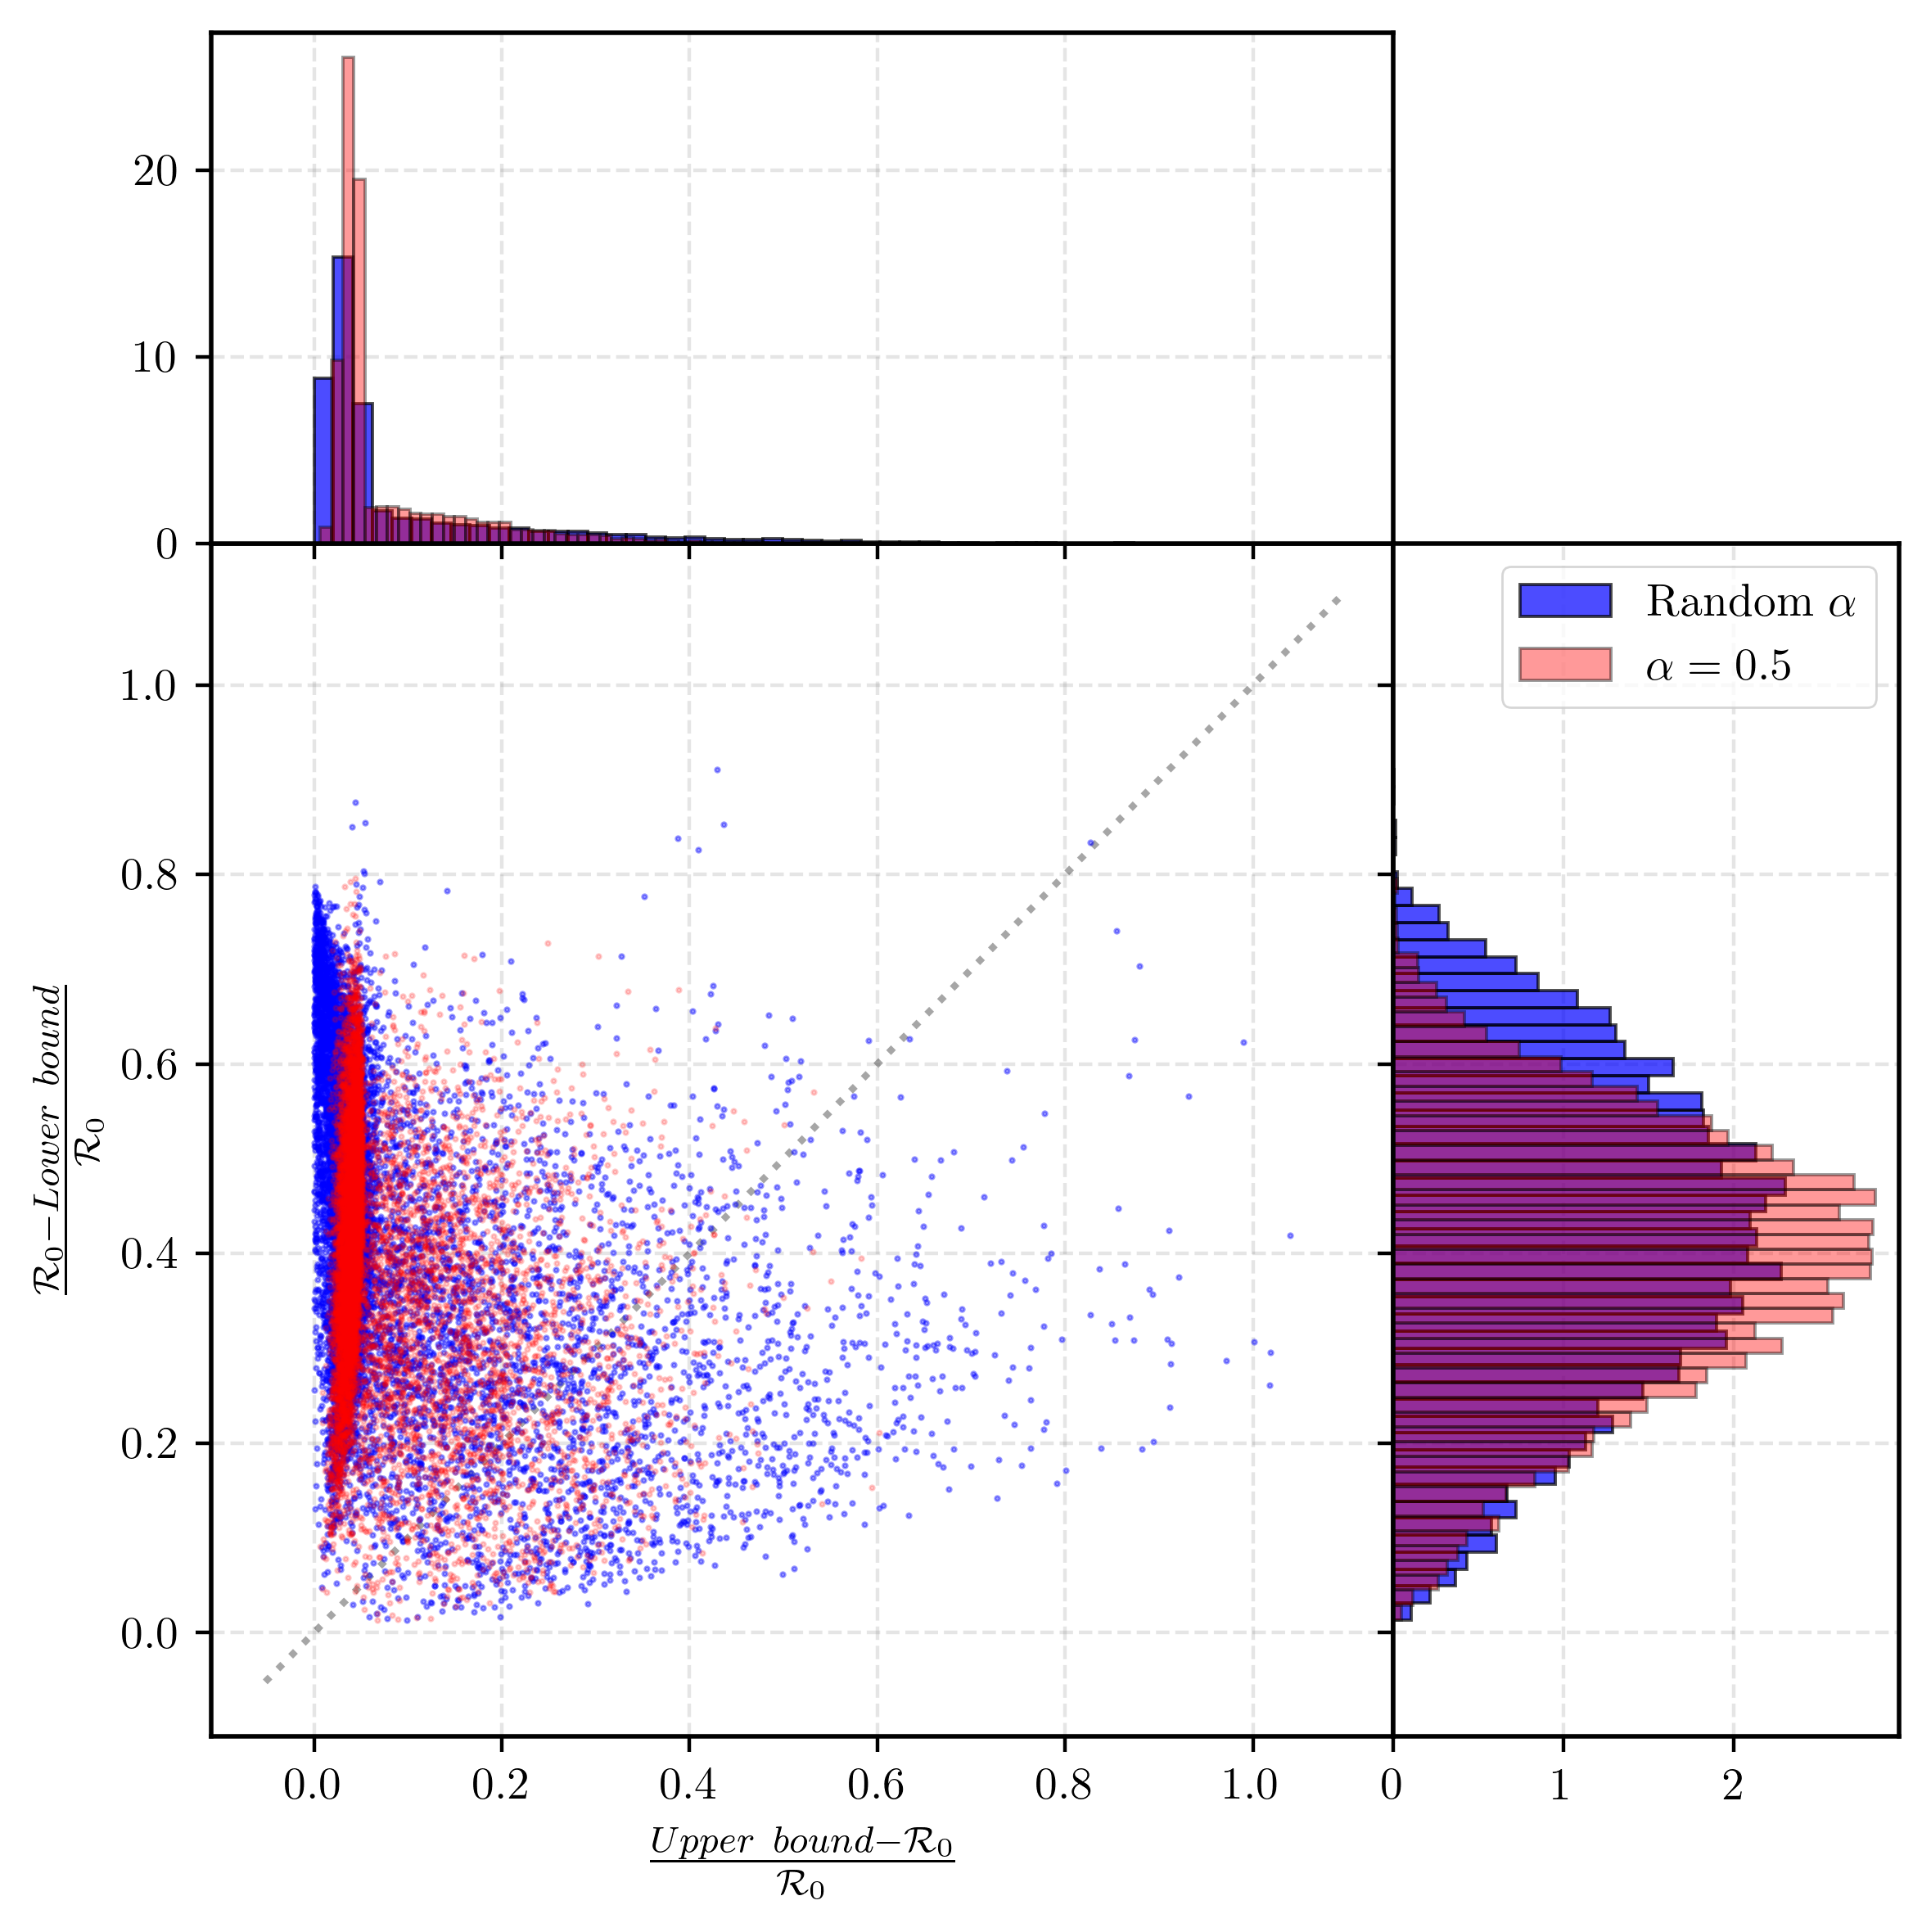

In [67]:

# Create the figure and subplots
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.7, 0.3], height_ratios=[0.3, 0.7], hspace=0, wspace=0)
axs = [
    fig.add_subplot(gs[1, 0]),  # Main plot
    fig.add_subplot(gs[0, 0]),  # Histogram - Upper Bound
    fig.add_subplot(gs[1, 1]),  # Histogram - Lower Bound
]

# Share x-axis and y-axis with the main plot
axs[1].sharex(axs[0])
axs[2].sharey(axs[0])

axs[0].grid(linestyle='--', color='grey', alpha=0.2)
axs[1].grid(linestyle='--', color='grey', alpha=0.2)
axs[2].grid(linestyle='--', color='grey', alpha=0.2)

# Remove tick labels and tick marks from shared axes
axs[1].tick_params(labelbottom=False)
axs[2].tick_params(labelleft=False)

# Main plot
axs[0].scatter(upper_bound_diff, lower_bound_diff, s=1, color='blue', alpha=0.4, zorder=2)
axs[0].scatter(upper_bound_diff_red, lower_bound_diff_red, s=1, color='red', alpha=0.2, zorder=3)
axs[0].set_xlabel(r'$\frac{Upper~bound - \mathcal{R}_0}{\mathcal{R}_0}$')
axs[0].set_ylabel(r'$\frac{\mathcal{R}_0 - Lower~bound}{\mathcal{R}_0}$')

# Histogram - Upper Bound
axs[1].hist(upper_bound_diff, bins=50, color='blue', alpha=0.7, density=True, ec='black', linewidth=0.7)
axs[1].hist(upper_bound_diff_red, bins=50, color='red', alpha=0.4, density=True, ec='black', linewidth=0.7)

# Histogram - Lower Bound
axs[2].hist(lower_bound_diff, bins=50, orientation='horizontal', color='blue', alpha=0.7, density=True,
            ec='black', linewidth=0.7, label=r'Random $\alpha$')
axs[2].hist(lower_bound_diff_red, bins=50, orientation='horizontal', color='red', alpha=0.4, density=True,
            ec='black', linewidth=0.7, label=r'$\alpha=0.5$')

axs[2].legend()

axs[0].plot(axs[0].get_xlim(), 
            axs[0].get_xlim(), 
            alpha=0.35,color='black', linestyle=':', zorder=1)

plt.tight_layout()

# Show the plot
plt.savefig('../images/bounds_rzero.pdf', bbox_inches='tight')
plt.show()